# **In this notebook we generate the analysis and plots for Fig. 4, exploratory analysis of real datasets**

In [7]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import glob
import importlib
import seaborn as sns

In [8]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [9]:
import monod
importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, analysis, mminference
from monod.analysis import *

In [10]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

**Download data and metadata for analysis**

In [ ]:
!wget --content-disposition https://data.caltech.edu/records/n4yzp-qdf66/files/explorData.tar.gz?download=1
!tar -xvf explorData.tar.gz

In [ ]:
#Gene length annotations
!wget --content-disposition https://raw.githubusercontent.com/pachterlab/CGP_2023/main/references/gg_200524_mouse_genome_polyA_cum_1

#Human reference (GRCh38-2020-A) for also available
!wget --content-disposition https://raw.githubusercontent.com/pachterlab/CGP_2023/main/references/gg_200525_genome_polyA_cum_3

In [1]:
!wget --content-disposition https://raw.githubusercontent.com/pachterlab/CGP_2023/main/metadata/all_pbmc_markers.csv

--2024-05-28 15:32:15--  https://raw.githubusercontent.com/pachterlab/CGP_2023/main/metadata/all_pbmc_markers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19736 (19K) [text/plain]
Saving to: ‘all_pbmc_markers.csv’

all_pbmc_markers.cs 100%[===================>]  19.27K  --.-KB/s    in 0.001s  

2024-05-28 15:32:15 (32.9 MB/s) - ‘all_pbmc_markers.csv’ saved [19736/19736]



In [ ]:
#meK-Means results
!wget --content-disposition https://github.com/pachterlab/CGP_2023/raw/main/analysis_output/meKruns_explor.tar.gz
!tar -xvf meKruns_explor.tar.gz

!wget --content-disposition https://data.caltech.edu/records/t8y1r-b5524/files/meKruns_explor_sd.tar.gz?download=1
!tar -xvf meKruns_explor_sd.tar.gz

### **Set up files and genes for inference**

In [44]:
#Threshold for filtering 
def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S are cellxgene
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    #if l == '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom':
    u_min = u_min
    s_min =  s_min


    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4) 
    
    
    return fitted_idx

In [45]:
#Looms, transcriptomes and (technical) sampling params

looms = ['./processed_brca1_raw.loom',
        './processed_pbmc_10k_raw.loom',
        './processed_E11E13_raw.loom']

transcrips = ['./gg_200524_mouse_genome_polyA_cum_1',
             './gg_200525_genome_polyA_cum_3',
             './gg_200524_mouse_genome_polyA_cum_1']

datas = ['brca1','pbmc','e11e13']
attribute_names =[('unspliced','spliced'),'gene_name','barcode']

tech_params = [[-6.777777777777778, -0.6999999999999997],
               [-5.666666666666666, -0.6999999999999997],
               [-6.777777777777778, -1.25]]

In [46]:
#List of Ks for each loom 
ks = [[5,10,15],[3,10,20],[2,5,10]] #15

In [6]:
#Genes for PBMCS
all_marks = pd.read_csv('./all_pbmc_markers.csv')
print(all_marks.head())

#From lit + https://satijalab.org/seurat/articles/pbmc3k_tutorial.html
toplot_marks = ['CD300E','FCGR2B','CD40',
                'CD69','MS4A1','CD79A','PTPRC',
                'CD3D','IL7R','LEF1','TRAC','CD4','CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','BLK','IGHD','VPREB3','CD28','IRF4','CCR6','GATA3','IL2RA','FOXP1','CD38',
               'CX3CR1','CD86','ADGRE1'] + ['CD14','FCGR3A','FCGR3B','CCR2','CCR5','CCR7',
'CD69','ITGAE','CTLA4','NCAM1','FOXP3','STAT4', 'TCF7','IL26',
'IL22','IL13','KLRB1','CXCR3','CD38',
'CLEC9A','ITGAX','XCR1','CD1C','CD207','ITGAM', 'NOTCH2',
'BATF3','CCR7','CD8A','CD8B',
'BCL2','BCL6','CD5','CD27','CD79B','SDC1','TLR9','XBP1','GZMB','IL3RA','CD74',
'IL7R', 'CCR7','LYZ','S100A4','GNLY', 'NKG7','FCER1A', 'CST3','PPBP','PF4'] 

pbmc_markers = list(all_marks['gene_name']) + toplot_marks #Added

pbmc_markers = list(np.unique(pbmc_markers)) #Added

  gene_name  num_cell_types
0     PTPRC              28
1      CD14              27
2     IL-7R              24
3      CD3D              24
4    FCG3RA              23


In [48]:
germ_markers = np.unique(['Bnc2', 'Dmrt1', 'Tet1', 'Ccnd3','Tbrg4', 'Rbm38', 
           'Supt6','Nanos2', 'Dnmt3l' ,'Piwil4', 'Pou5f1',
           'Stra8', 'Rec8','Nanog','Lefty1', 'Lefty2','Pycr2',
          'Id1','Bmp2','Fst','Inhbb','Grem2',
          'Cdx2','Gata2','Msx1','Msx2','Zfp42','Lhx1',
          'Stra8', 'Sycp1', 'Sycp3', 'Sync3', 'Spo11', 'Ccdc155', 'Dmc1', 'Mei1',
           'Mei4', 'Meioc', 'Hormad1', 'Hormad2', 'Msh5', 'Tex11', 'Prdm9', 'Zglp1', 'Smc1b',
          'Pitx2','Otx2','Gata2', 'Id1', 'Id2', 'Id3', 'Cdx2', 'Smad6', 'Dlx3', 'Msx1', 'Msx2',
            'Gata2' ,'Nr3c1','Kdm5a','Pbx3','Phf8','Lef1','Cdx2','Hcfc1','Eomes','E2f5',
            'Hdac2','Nr2c1','Rela','Maz','Atf4','Jun','Otx2','Egr4','Myc','Bcas2'])

BRCA1-null cells had increased expression of basal-associated genes such as Krt14, Vim and Sparc (Figure 1D–E). Intriguingly, the BRCA1-null tumor cells could be segregated further into cells with basal (Cluster 4) and mesenchymal (Cluster 5) features, respectively (Figure 1D). Cluster 4 cells expressed higher levels of epithelial genes (Cldn4, Cldn3, Epcam) whereas Cluster 5 was defined by expression of mesenchymal genes (Vim, Sparc, Col3a1, Bgn)

The BRCA1-1 cluster consisted of proliferating cells with increased expression of cell cycle related genes such as Birc5, Tyms and Mki67. BRCA1-5 was a cluster with strongest expression of prototypical basal genes such as Krt14 and Igfbp5. Interestingly, BRCA1-2 cells exhibited a partial EMT gene expression pattern with moderate levels of collagens and the highest levels of EMT transcription factors such as Yap1, Twist1 and Zeb1 (Figure 4B). On the other hand, BRCA1-3 cells expressed the highest levels of genes associated with fibroblasts (Figure 4B) and this would fit with our previous observations of a sub-population of BRCA1 null cells with mesenchymal characteristics (Figures 1–3). Within this predominantly basal tumor type, cells with features of AvPs (BRCA1-4) were also present with elevated levels of Cldn3, Malat1, Krt18, Wfdc18 and Mfge8. Once again, the extensive heterogeneity within these BRCA1-null tumors were apparent along with the genes and pathways for each of these clusters (Figure 4—source datas 1–2).

While the association between proliferation (cluster BRCA1-1) and poor prognosis may not be too surprising (van Diest et al., 2004), the observation that alveolar progenitor-like (cluster BRCA1-4) gene expression was associated with poorer survival is interesting and worthy of further examination in future work. Since CD14 protein expression can be detected in a subset of BRCA1-null mouse tumor cells (Figure 5—figure supplement 1A), as well as human breast cancers

In [49]:
#also from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6800274/
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10132032/
brca_markers = np.unique(['Krt14', 'Vim','Sparc',
                         'Cldn4', 'Cldn3', 'Epcam',
                         'Vim', 'Sparc', 'Col3a1', 'Bgn',
                         'Birc5', 'Tyms','Mki67',
                         'Krt14','Igfbp5','Yap1', 'Twist1',
                          'Zeb1','Cldn3', 'Malat1', 'Krt18', 
                          'Wfdc18','Mfge8',
                         'Rbfox2','Sf3b1','Srsf2','U2af1',
                         'Zrsf2',' Srsf1', 'Srsf2', 'Srsf3','U2af65',
                         'Pkm1','Pkm2','Ilf3','Qki','Rbm5',
                         'Hipk2','Bin1', 'Bim','Bcl2l11','Mcl1', 'Casc4',
                         'Ron', 'Mknk2', 'S6k1', 'Casc4', 'Prrc2c',
                         'Casp8','Fas','Fbln2','Mcl1','Bcl2l1','Bcl2l11','Bin1','Casp2',
                        'Pkm','Hif1a','Numb','Ezh2','Map2k7','Her2','Mdm2','Gap17','Egfr',
                        'Birc5','Ccnd1','Hras','Mknk2','Rps6kb1','Klf6','Pten','Il1rap','Cd19','Cd47',
                        'Tert','Cd45','Il7','Fn1','Cd44','Ceacam1','Enah','Mstr1','Tnc','Fgfr2','Vegfa','Irf3',
                        'Exoc7','Kat5','Tip60','Brca1',
                         'Esrp1','Esrp2','Hnrnpa1','Hnrnpi','Hnrnpm','Rbm6','Rbm10','Srsf1','Srsf3',
                          'Srsf4','Srsf5','Srsf6','Tra2b','Cd14'])

**Go through looms and select genes that include lists above**

In [50]:
all_markers = [brca_markers,pbmc_markers,germ_markers]

In [51]:
ks

[[5, 10, 15], [3, 10, 20], [2, 5, 10]]

### **Fit meK-Means for range of Ks**

**Make files for meK-Means runs and select genes**

In [ ]:
!mkdir ./fits

In [52]:
!mkdir ./fits/explorData #_0313

dir_strings = []
data_strings = []
result_strings = []


for loom,transc,data_name,g_lit,tech_tup,Ks in zip(looms,transcrips,datas,all_markers,tech_params,ks):
    
    ds = lp.connect(loom)
    g_names = ds.ra[attribute_names[1]]
    num_genes = len(g_names)
    num_cells = len(ds.ca[attribute_names[2]])
    
    U = ds.layers['unspliced'][:,:].T
    S = ds.layers['spliced'][:,:].T
    if data_name == 'e11e13':
        true_labs = list(ds.ca['subclass_label'])
    ds.close()
    
    
    g_filt = nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02)
    g_filt_lit = pd.Categorical(g_names).isin(g_lit)
    
    if 'pbmc' not in data_name:
        adata = anndata.AnnData(X=S)
        adata.layers["counts"] = adata.X.copy()  # preserve counts
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata.raw = adata
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        g_filt_hvg = adata.var.highly_variable
    else:
        g_filt_hvg = g_filt_lit #Just using lit genes here
        g_filt_lit = g_filt_lit & g_filt
        
    final_filt = (g_filt_lit) | (g_filt_hvg & g_filt) #Filter hvgs + add lit genes
    final_names = g_names[final_filt]
    
    print(data_name+' with '+str(len(final_names))+' genes')
    print('Num lit genes used: ',np.sum(g_filt_lit)) #&g_filt
    
    #------- Run meK-Means ----------
    #Define bounds for params
    phys_lb = [-3.0, -3, -3 ] 
    phys_ub = [4.2, 2.5, 2.5] 
    samp_lb = tech_tup 
    samp_ub = tech_tup  
    gridsize = [1,1] #Already have tech params


    epochs = 10

    for clus in Ks:
        #Set up files for Monod
        dir_string,dataset_string = monod.preprocess.construct_batch([loom], \
                                                 transc, \
                                                 [data_name], \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits/explorData',\
                                                 meta=data_name+'_K'+str(clus),batch_id=1,\
                                                 n_genes=len(final_names),exp_filter_threshold=None,
                                                 viz=False,genes_to_fit=final_names) #explorData_0313
        dir_strings += [dir_string]
        data_strings += [dataset_string]
    
        # ---------------- meK-Means Inference ---------------- 
        #Define model with bursty transcription and Poisson molecule capture/sampling
        fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

        #Set up mminference parameters
        inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                    dataset_string[0],fitmodel,k=clus,epochs=epochs,use_lengths = True,
                    gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

        #Read in loom file with filtered barcodes
        search_data = monod.extract_data.extract_data(loom, transc, data_name,
                    dataset_string[0], dir_string, viz=False, dataset_attr_names=attribute_names)

        #Run inference(fit_all_grid_points()) and Save result file strings
        full_result_string = inference_parameters.fit_all_grid_points(40,search_data) 

        result_strings.append(full_result_string)
        print('Result: ',full_result_string)


        # ----------------  Save output ---------------- 
        #Read in results and get cluster assignments
        sr = [monod.analysis.load_search_results(i) for i in full_result_string]


        cat_assigns = np.array([None]*num_cells) #cat_assigns is empty list of length = no. cell barcodes
        for i in range(len(sr)):
            r = sr[i]
            cat_assigns[r.filt] = r.assigns #denotes which cluster (k), cells were assigned to

        print('No. clus: ',len(np.unique(cat_assigns)))


        if data_name == 'e11e13':
            print('ARI: ',adjusted_rand_score(true_labs,cat_assigns))
            


mkdir: cannot create directory ‘/home/tchari/perturbCME/notebooks/fits/explorData_0313’: File exists
mkdir: cannot create directory ‘/home/tchari/perturbCME/notebooks/fits/explorData_0315’: File exists


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


pbmc with 763 genes
Num lit genes used:  763


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  3.08s/it]


mstep self.weights:  [5.51053814e-04 7.89992977e-03 8.15453804e-03 4.24534174e-04
 2.64382133e-03 5.85587105e-03 2.58928826e-02 2.22301141e-03
 1.10136424e-02 2.15183744e-01 4.43430830e-02 1.44700203e-01
 3.89370683e-01 6.88651069e-02 5.17212923e-03 3.71915830e-02
 1.02907807e-02 7.18597011e-03 1.28747376e-02 1.62694732e-04]
Q Function:  -10760768.41317729



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:59<00:00,  4.60s/it]


mstep self.weights:  [9.09338909e-11 7.36564525e-03 2.55552947e-04 9.09338909e-11
 9.09338909e-11 5.69902601e-04 2.70817619e-02 9.09338909e-11
 9.11859590e-11 1.64801987e-01 5.58622092e-02 1.43286159e-01
 4.16567575e-01 1.13476104e-01 7.26665741e-03 3.67113413e-02
 9.09338909e-11 7.17845594e-03 1.95766474e-02 9.09338909e-11]
Q Function:  -9727820.09316109



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:57<00:00,  5.27s/it]


mstep self.weights:  [9.09338909e-11 7.27471136e-03 9.09338909e-11 9.09338909e-11
 9.09338909e-11 9.09338909e-11 1.59976842e-02 9.09338909e-11
 9.09338909e-11 1.61964104e-01 5.52309483e-02 1.40855970e-01
 4.18176776e-01 1.25860760e-01 9.82231429e-03 3.47180093e-02
 9.09338909e-11 6.77466852e-03 2.33240530e-02 9.09338909e-11]
Q Function:  -9705448.99232608



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.16s/it]


mstep self.weights:  [9.09338909e-11 7.27471136e-03 9.09338909e-11 9.09338909e-11
 9.09338909e-11 9.09338909e-11 6.19788930e-07 9.09338909e-11
 9.09338909e-11 1.72347446e-01 5.51025602e-02 1.38098721e-01
 4.19423588e-01 1.29883235e-01 1.29339924e-02 3.26819891e-02
 9.09338909e-11 5.78502987e-03 2.64681066e-02 9.09338909e-11]
Q Function:  -9717158.926901923



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.90s/it]


mstep self.weights:  [9.09338909e-11 7.27471136e-03 9.09338909e-11 9.09338909e-11
 9.09338909e-11 9.09338909e-11 9.09338909e-11 9.09338909e-11
 9.09338909e-11 1.76333365e-01 5.48646731e-02 1.34972938e-01
 4.20043486e-01 1.22381894e-01 1.68636157e-02 3.20033705e-02
 9.09338909e-11 4.24555769e-03 3.10163876e-02 9.09338909e-11]
Q Function:  -9702598.399565492



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.13s/it]


mstep self.weights:  [9.09338909e-11 7.27471136e-03 9.09338909e-11 9.09338909e-11
 9.09338909e-11 9.09338909e-11 9.09338909e-11 9.09338909e-11
 9.09338909e-11 1.76185514e-01 5.47818423e-02 1.33401583e-01
 4.20232885e-01 1.16154462e-01 1.94761671e-02 3.16537687e-02
 9.09338909e-11 3.09779243e-03 3.77412733e-02 9.09338909e-11]
Q Function:  -9715315.71416183



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.09s/it]


mstep self.weights:  [9.09338909e-11 7.27471136e-03 9.09338909e-11 9.09338909e-11
 9.09338909e-11 9.09338909e-11 9.09338909e-11 9.09338909e-11
 9.09338909e-11 1.75766607e-01 5.42749974e-02 1.32128747e-01
 4.19101866e-01 1.10792920e-01 2.40342354e-02 3.06724329e-02
 9.09338909e-11 1.52706910e-03 4.44264122e-02 9.09338909e-11]
Q Function:  -9710808.241685811



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]


mstep self.weights:  [9.09338909e-11 7.27471136e-03 9.09338909e-11 9.09338909e-11
 9.09338909e-11 9.09338909e-11 9.09338909e-11 9.09338909e-11
 9.09338909e-11 1.75055404e-01 5.61727464e-02 1.32106187e-01
 4.16238612e-01 1.07121482e-01 2.64727237e-02 2.97033622e-02
 9.09338909e-11 9.09339818e-05 4.97638364e-02 9.09338909e-11]
Q Function:  -9705902.91844758



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:59<00:00,  6.62s/it]


mstep self.weights:  [9.09338909e-11 7.27471136e-03 9.09338909e-11 9.09338909e-11
 9.09338909e-11 9.09338909e-11 9.09338909e-11 9.09338909e-11
 9.09338909e-11 1.72779351e-01 5.64698700e-02 1.32827198e-01
 4.15489176e-01 1.04567285e-01 2.62949590e-02 2.92104712e-02
 9.09338909e-11 9.09338909e-11 5.50869772e-02 9.09338909e-11]
Q Function:  -9715446.814953396



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:01<00:00,  6.82s/it]


mstep self.weights:  [9.09338909e-11 7.27471136e-03 9.09338909e-11 9.09338909e-11
 9.09338909e-11 9.09338909e-11 9.09338909e-11 9.09338909e-11
 9.09338909e-11 1.73468257e-01 5.63321017e-02 1.33147574e-01
 4.15000228e-01 1.02163051e-01 2.66012987e-02 2.89808892e-02
 9.09338909e-11 9.09338909e-11 5.70318868e-02 9.09338909e-11]
Q Function:  -9708754.518575538

Result:  ['./fits/explorData_0315/gg_240403_029_pbmc_K20_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_1.res', './fits/explorData_0315/gg_240403_029_pbmc_K20_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_9.res', './fits/explorData_0315/gg_240403_029_pbmc_K20_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_10.res', './fits/explorData_0315/gg_240403_029_pbmc_K20_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_11.res', './fits/explorData_0315/gg_240403_029_pbmc_K20_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_12.res', './fits/explorData_0315/gg_240403_029_pbmc_K20_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_13.res', './fits/explorData_0315/gg_24040

### **QC and Analysis of Results**

In [160]:
result_strings

[['./fits/explorData_0313/gg_240312_025_brca1_K5_1/brca1/Bursty_Poisson_1x1/grid_scan_results_3.res',
  './fits/explorData_0313/gg_240312_025_brca1_K5_1/brca1/Bursty_Poisson_1x1/grid_scan_results_4.res'],
 ['./fits/explorData_0313/gg_240312_025_brca1_K10_1/brca1/Bursty_Poisson_1x1/grid_scan_results_2.res',
  './fits/explorData_0313/gg_240312_025_brca1_K10_1/brca1/Bursty_Poisson_1x1/grid_scan_results_3.res',
  './fits/explorData_0313/gg_240312_025_brca1_K10_1/brca1/Bursty_Poisson_1x1/grid_scan_results_7.res'],
 ['./fits/explorData_0313/gg_240312_025_brca1_K15_1/brca1/Bursty_Poisson_1x1/grid_scan_results_0.res',
  './fits/explorData_0313/gg_240312_025_brca1_K15_1/brca1/Bursty_Poisson_1x1/grid_scan_results_1.res',
  './fits/explorData_0313/gg_240312_025_brca1_K15_1/brca1/Bursty_Poisson_1x1/grid_scan_results_8.res'],
 ['./fits/explorData_0313/gg_240312_025_pbmc_K3_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_0.res',
  './fits/explorData_0313/gg_240312_025_pbmc_K3_1/pbmc/Bursty_Poisson_1x1/g

In [54]:
col_all_par = '#4472C4'
col_b = '#1B9AAA'
col_beta = '#9fcbee'
col_gamma ='#3C50B1'
col_expr = '#9299A0'


In [55]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [56]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [57]:
#Plot cluster concordance with true labels and distribution of clusters

def vis_assign(assign,true=None,title='',log=True,figsize=(18, 5),palette='tab20',fname=None):
    '''
    Plot distribution of cluster assignments (optional: with previous annotations)

    assign: np.array of cluster assignments (1..k) for each cell
    true: list of user-given cluster assignments (string) for each cell, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    save_file: string, output file to save image

    '''
 
    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    if true is not None:
        hues = true
    else:
        hues = assign 
        
    if log:
        plt.yscale('log')
    
    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax,
                    palette=palette,multiple="dodge",
                    discrete=True)

    plt.xticks(np.arange(0,np.max(assign)+1))
    


    ax.set_xlabel('meK-Means Cluster Assignment')
    ax.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



In [58]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,fname=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)


In [59]:
def print_summary(sr):
    '''
    Get summary of clustering results
    '''
    print('--------------------------')
    print('Model AIC Score: ',sr[0].aic[0])
    for r in sr:
        print('Clus '+str(r.assigns)+' with '+str(np.sum(r.filt))+' cells')
    print('--------------------------')

In [11]:
to_find = ['./fits/explorData_0313/gg_240312_025_brca1_K5_1/brca1/Bursty_Poisson_1x1/*.res',
          './fits/explorData_0313/gg_240312_025_brca1_K10_1/brca1/Bursty_Poisson_1x1/*.res',
          './fits/explorData_0313/gg_240312_025_brca1_K15_1/brca1/Bursty_Poisson_1x1/*.res',
          './fits/explorData_0313/gg_240312_025_pbmc_K3_1/pbmc/Bursty_Poisson_1x1/*.res',
          './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/*.res',
          './fits/explorData_0313/gg_240312_025_pbmc_K20_1/pbmc/Bursty_Poisson_1x1/*.res',
          './fits/explorData_0313/gg_240312_025_e11e13_K2_1/e11e13/Bursty_Poisson_1x1/*.res',
           './fits/explorData_0313/gg_240312_025_e11e13_K5_1/e11e13/Bursty_Poisson_1x1/*.res',
          './fits/explorData_0313/gg_240312_025_e11e13_K10_1/e11e13/Bursty_Poisson_1x1/*.res'] #Read in previously downloaded results

result_strings = []
for f in to_find:
    result_strings += [glob.glob(f)]

In [12]:
looms = ['./processed_brca1_raw.loom',
         './processed_brca1_raw.loom',
         './processed_brca1_raw.loom',
        './processed_pbmc_10k_raw.loom',
         './processed_pbmc_10k_raw.loom',
         './processed_pbmc_10k_raw.loom',
        './processed_E11E13_raw.loom',
        './processed_E11E13_raw.loom',
        './processed_E11E13_raw.loom']

In [13]:
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings if 'upd' not in i]]

len(sr)

9

In [17]:
#SearchData objects, with U/S
sd = []
for strings in result_strings:

    sd += [[monod.analysis.load_search_data(i[:i.find('Bursty')]+'raw.sd') for i in strings]]

len(sd)

9

In [16]:
[(i[:-24]+'raw.sd') for i in to_find]

['./fits/explorData_0313/gg_240312_025_brca1_K5_1/brca1/raw.sd',
 './fits/explorData_0313/gg_240312_025_brca1_K10_1/brca1/raw.sd',
 './fits/explorData_0313/gg_240312_025_brca1_K15_1/brca1/raw.sd',
 './fits/explorData_0313/gg_240312_025_pbmc_K3_1/pbmc/raw.sd',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/raw.sd',
 './fits/explorData_0313/gg_240312_025_pbmc_K20_1/pbmc/raw.sd',
 './fits/explorData_0313/gg_240312_025_e11e13_K2_1/e11e13/raw.sd',
 './fits/explorData_0313/gg_240312_025_e11e13_K5_1/e11e13/raw.sd',
 './fits/explorData_0313/gg_240312_025_e11e13_K10_1/e11e13/raw.sd']

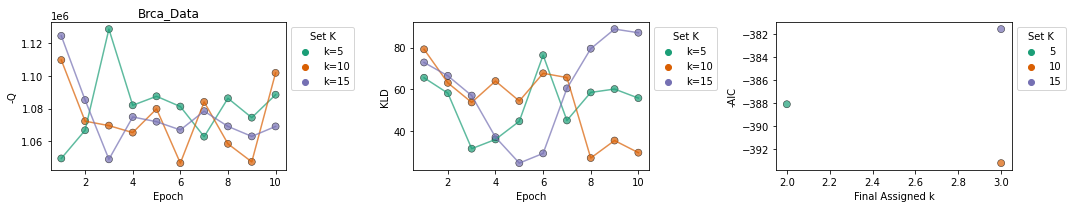

In [271]:
#Plot AICs over Ks for each dataset
vis_metrics(sr[0:3],'Brca_Data',ks[0],figsize=(15,3),fname='brca_k_metrics.pdf')

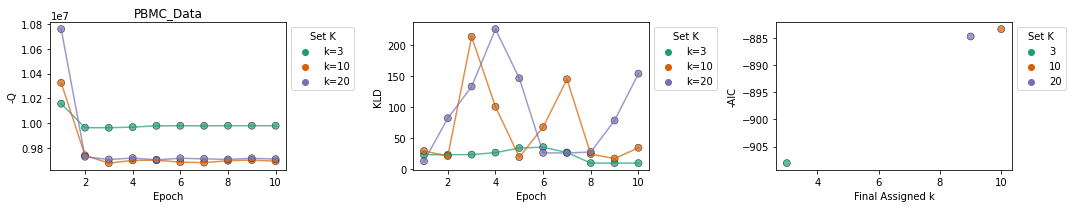

In [65]:
vis_metrics(sr[3:6],'PBMC_Data',ks[1],figsize=(15,3),fname='pbmc_k_metrics.pdf')

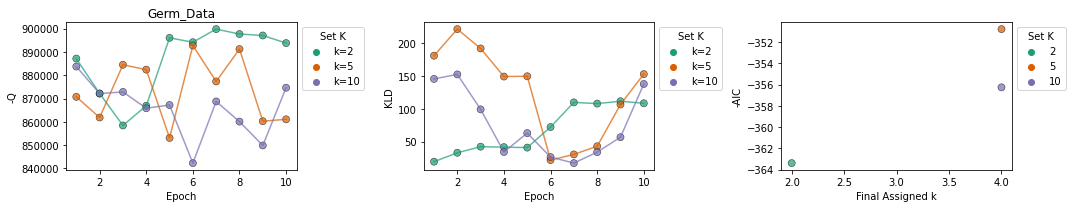

In [273]:
vis_metrics(sr[6:],'Germ_Data',ks[2],figsize=(15,3),fname='germ_k_metrics.pdf')

In [351]:
#Choose clustering for each dataset (which of the three Ks tested)
chosen_inds = [2,4,7] #brca, pbmc, germ

chosen_sr = [sr[i] for i in chosen_inds]
chosen_sd = [sd[i] for i in chosen_inds]
chosen_loom = [looms[i]for i in chosen_inds]
chosen_res_strings = [result_strings[i] for i in chosen_inds]

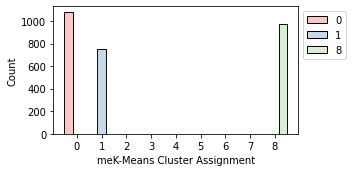

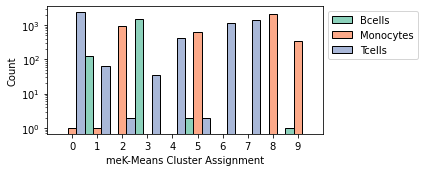

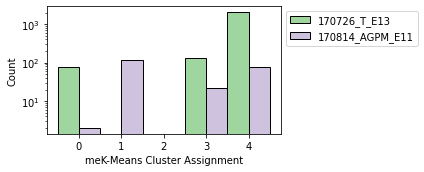

In [1031]:
#Get cluster assignments for each dataset
labels = []
palettes = ['Pastel1','Set2','Accent']
fnames = ['brca','pbmc','germ']
for r,l,p,f in zip(chosen_sr,chosen_loom,palettes,fnames):
    labels += [get_assigns(r)]
    if 'brca' in l:
        vis_assign(get_assigns(r),true=None,title='',log=False,figsize=(5, 2.5),palette=p,fname=f+'_clus_hist.pdf')
    else:
        ds = lp.connect(l)
        true_labs = ds.ca['subclass_label']
        ds.close()
        vis_assign(get_assigns(r),true=true_labs,title='',figsize=(6, 2.5),palette=p,fname=f+'_clus_hist.pdf')

Check PBMC cluster identities with known markers

In [356]:
# Plot clusters with raw counts, pre-gene filter
#Remove BLK, FCGR3B, XCR1,BCL6,SDC1,CD207,IL22,CCR5,IL13,IL26,CTLA4
toplot_marks = ['CD300E','FCGR2B','CD40',
                'CD69','MS4A1','CD79A','PTPRC',
                'CD3D','IL7R','LEF1','TRAC','CD4','CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','IGHD','VPREB3','CD28','IRF4','CCR6','GATA3','IL2RA','FOXP1','CD38',
               'CX3CR1','CD86','ADGRE1','CD33','CD64'] + ['CD14','FCGR3A','CCR2','CCR7',
'CD69','ITGAE','NCAM1','FOXP3','STAT4', 'TCF7',
'KLRB1','CXCR3','CD38',
'CLEC9A','ITGAX','CD1C','ITGAM', 'NOTCH2',
'BATF3','CCR7','CD8A','CD8B',
'BCL2','CD5','CD27','CD79B','TLR9','XBP1','GZMB','IL3RA','CD74',
'IL7R', 'CCR7','LYZ','S100A4','GNLY', 'NKG7','FCER1A', 'CST3','PPBP','PF4']

In [357]:
pbmc_loom = lp.connect(chosen_loom[1])
p_S = pbmc_loom.layers['spliced'][:,:].T
g_names = pbmc_loom.ra[attribute_names[1]]
pbmc_loom.close()

In [358]:
#Mean per gene for all genes before filtering for genes
raw_clus = p_S
print(raw_clus.shape)

#Do library-size normalization of spliced counts as is standard
tots = np.sum(raw_clus,axis=1)
divids = (1e4/tots)[:,None]
raw_clus = raw_clus*divids

print(raw_clus.shape)

assigned = np.unique(get_assigns(chosen_sr[1]))
mean_g = np.zeros((len(assigned),raw_clus.shape[1]))

conv_assign = []
for i in range(len(chosen_sr[1])):
    to_use = chosen_sr[1][i]
    conv_assign += [to_use.assigns]
    mean_g[i,:] = np.mean(raw_clus[to_use.filt,:],axis=0)
    
print('Assignments: ',dict(zip(range(len(conv_assign)),conv_assign)))

(10997, 36601)
(10997, 36601)
Assignments:  {0: 2, 1: 7, 2: 1, 3: 9, 4: 3, 5: 4, 6: 5, 7: 8, 8: 0, 9: 6}


In [359]:
inds = [list(g_names).index(i) for i in np.unique(toplot_marks) if i in g_names]

In [360]:
df = pd.DataFrame(np.log10(mean_g[:,inds].T+1))
df.index = g_names[inds]


df.head()

,0,1,2,3,4,5,6,7,8,9
ADGRE1,0.084080,0.001738,0.005564,0.314723,0.003486,0.003579,0.094615,0.139803,0.017730,0.016465
BATF3,0.026706,0.005654,0.008857,0.258460,0.001602,0.006341,0.114316,0.031359,0.003026,0.006265
BCL2,0.021631,0.216004,0.114505,0.011512,0.219606,0.121594,0.080201,0.023636,0.290024,0.297556
CCL5,0.000000,0.089499,0.007749,0.002216,0.001198,0.111305,0.006625,0.000884,0.008456,0.023313
CCR2,0.231071,0.080274,0.175740,0.006181,0.005455,0.012687,0.219481,0.269054,0.005587,0.046225


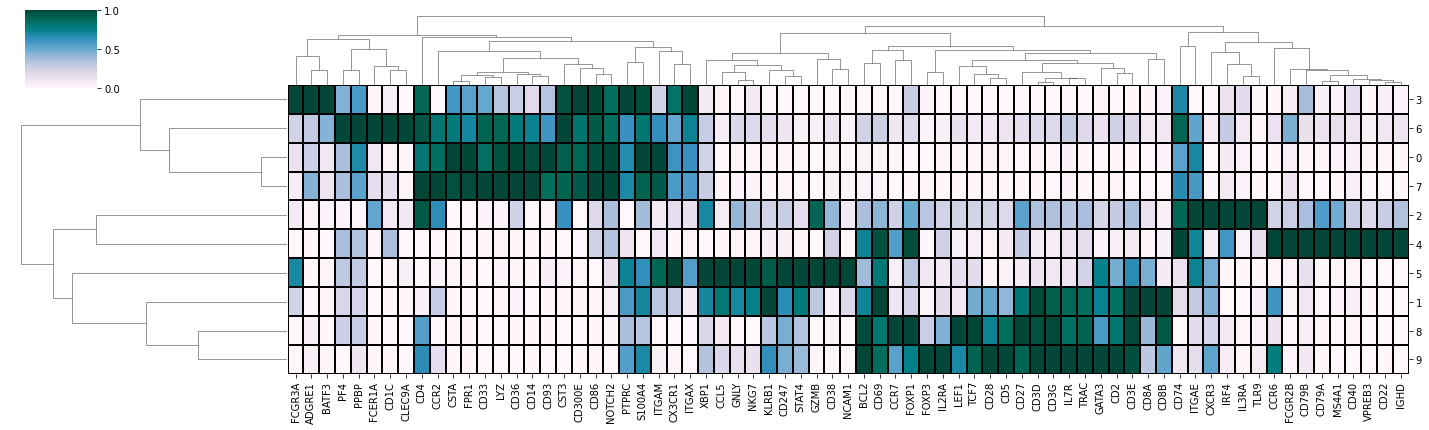

In [361]:
g=sns.clustermap(df.T,figsize=(20,6),standard_scale=1,cmap="PuBuGn",
               linewidths=0.01,linecolor='black')

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('2403017_meKMeans_clustermap_pbmc.pdf')

In [364]:
# mean_g[[0,6,7,3],g_names=='ZFP36']

Check Germ cell cluster identities with known markers

In [368]:
#Check germ cells

#Ccnd3, Bnc2, Tet1 -->splicing goes down over development in testes

for x,s in zip(chosen_sr[2],chosen_sd[2]):
    print(x.assigns)
    print(10**x.param_estimates[0,s.gene_names=='Ccnd3',1])
    print()

1
[0.92384787]

3
[0.70697428]

4
[0.56530448]

0
[0.20834601]



In [371]:
#Check germ cells

#Ccnd3, Bnc2m, Tet1

for x,s in zip(chosen_sr[2],chosen_sd[2]):
    print(x.assigns)
    print(10**x.param_estimates[0,s.gene_names=='Bnc2',1])
    print()

1
[2.2270411]

3
[0.6784562]

4
[0.49923498]

0
[0.2682117]



In [1517]:
germ_loom = lp.connect(chosen_loom[2])
g_S = germ_loom.layers['spliced'][:,:].T
g_names = germ_loom.ra[attribute_names[1]]
germ_loom.close()

#Mean per gene for all genes before filtering for genes
raw_clus = g_S
print(raw_clus.shape)

#Do library-size normalization of spliced counts as is standard
tots = np.sum(raw_clus,axis=1)
divids = (1e4/tots)[:,None]
raw_clus = raw_clus #*divids

print(raw_clus.shape)

assigned = np.unique(get_assigns(chosen_sr[2]))
mean_g = np.zeros((len(assigned),raw_clus.shape[1]))

conv_assign = []
for i in range(len(chosen_sr[2])):
    to_use = chosen_sr[2][i]
    conv_assign += [to_use.assigns]
    mean_g[i,:] = np.mean(raw_clus[to_use.filt,:],axis=0)
    
print('Assignments: ',dict(zip(range(len(conv_assign)),conv_assign)))

(2464, 21103)
(2464, 21103)
Assignments:  {0: 1, 1: 3, 2: 4, 3: 0}


In [1518]:
inds = [list(g_names).index(i) for i in ['Nanog','Pou5f1','Nanos2','Piwil4',
                                         'Dnmt3l','Grem2','Bmp2'] if i in g_names]

df = pd.DataFrame(np.log10(mean_g[:,inds].T+1))
df.index = g_names[inds]


df.head()

,0,1,2,3
Nanog,0.549862,0.201645,0.143570,0.368782
Pou5f1,0.926571,0.329675,0.283865,0.482725
Nanos2,0.000000,0.254959,0.287903,0.286696
Piwil4,0.000000,0.008379,0.012542,0.000000
Dnmt3l,0.000000,0.045475,0.049233,0.027323


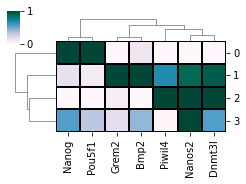

In [1519]:
g=sns.clustermap(df.T,figsize=(3.5,2.5),standard_scale=1,cmap="PuBuGn",
               linewidths=0.01,linecolor='black')

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('240326_meKMeans_clustermap_germ.pdf')

Check BRCA1 cluster identities with known markers

In [1623]:
brca_loom = lp.connect(chosen_loom[0])
brca_S = brca_loom.layers['spliced'][:,:].T
brca_g_names = brca_loom.ra[attribute_names[1]]
brca_loom.close()

Birc5, Tyms and Mki67. BRCA1-5 was a cluster with strongest expression of prototypical basal genes such as Krt14 and Igfbp5. Interestingly, BRCA1-2 cells exhibited a partial EMT gene expression pattern with moderate levels of collagens and the highest levels of EMT transcription factors such as Yap1, Twist1 and Zeb1 (Figure 4B). On the other hand, BRCA1-3 cells expressed the highest levels of genes associated with fibroblasts (Figure 4B) and this would fit with our previous observations of a sub-population of BRCA1 null cells with mesenchymal characteristics (Figures 1–3). Within this predominantly basal tumor type, cells with features of AvPs (BRCA1-4) were also present with elevated levels of Cldn3, Malat1, Krt18, Wfdc18 and Mfge8

In [1625]:
gs = ['Cldn4','Cldn3','Epcam','Vim','Sparc','Col3a1','Bgn',
     'Birc5', 'Tyms','Mki67',
     'Krt14','Igfbp5','Sfn','Phlda3','Wnt10a',
     'Malat1', 'Krt18', 'Wfdc18', 'Mfge8',
     'Yap1','Twist1','Zeb1',
     'Col1a2']
for t in gs:
    print(t)
    print('--------------')
    for r,s in zip(chosen_sr[0],chosen_sd[0]):
        print(r.assigns)
        print(np.mean(brca_S[r.filt,brca_g_names==t],axis=0))
        print(t in s.gene_names)
        print()

Cldn4
--------------
1
0.33862433
True

8
0.66564417
True

0
8.204461
True

Cldn3
--------------
1
0.96164024
True

8
1.6625767
True

0
19.090149
True

Epcam
--------------
1
2.601852
True

8
4.842536
True

0
47.585503
True

Vim
--------------
1
39.636242
True

8
1.4120654
True

0
17.32342
True

Sparc
--------------
1
48.634922
True

8
0.8026585
True

0
6.652416
True

Col3a1
--------------
1
20.3082
True

8
0.17382413
True

0
0.78066915
True

Bgn
--------------
1
8.613756
True

8
0.13087934
True

0
0.44144982
True

Birc5
--------------
1
0.24603175
True

8
0.06646217
True

0
1.232342
True

Tyms
--------------
1
0.27248678
True

8
0.034764826
True

0
0.83829
True

Mki67
--------------
1
0.11375661
True

8
0.038854804
True

0
0.46375465
True

Krt14
--------------
1
1.8875661
True

8
2.4141104
True

0
40.65892
True

Igfbp5
--------------
1
5.203704
True

8
1.3149284
True

0
9.222119
True

Sfn
--------------
1
0.8862434
False

8
0.89059305
False

0
14.929368
False

Phlda3
--------------
1


In [928]:
param_arr = []
clus_names = []

for r in chosen_sr[0]:
    clus_names += [r.assigns]
    param_arr += [r.param_estimates]
    m1 = 
    m2 = r.param_estimates[0,:,k]
    offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
    par_vals8[0,:,k] -= offset

param_arr = np.array(param_arr)[:,0,:,:]
clus_names = dict(zip(range(len(clus_names)),clus_names))
print(clus_names)


{0: 1, 1: 8, 2: 0}


In [1667]:
#Mean per gene for all genes before filtering for genes
raw_clus = brca_S
print(raw_clus.shape)

#Do library-size normalization of spliced counts as is standard
tots = np.sum(raw_clus,axis=1)
divids = (1e4/tots)[:,None]
raw_clus = raw_clus*divids

print(raw_clus.shape)

assigned = np.unique(get_assigns(chosen_sr[0]))
mean_g = np.zeros((len(assigned),raw_clus.shape[1]))

conv_assign = []
for i in range(len(chosen_sr[0])):
    to_use = chosen_sr[0][i]
    conv_assign += [to_use.assigns]
    mean_g[i,:] = np.mean(raw_clus[to_use.filt,:],axis=0)
    
print('Assignments: ',dict(zip(range(len(conv_assign)),conv_assign)))

(2810, 32285)
(2810, 32285)
Assignments:  {0: 1, 1: 8, 2: 0}


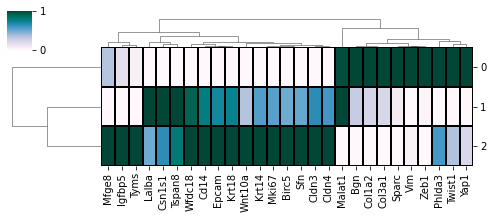

In [1674]:
inds = [list(brca_g_names).index(i) for i in np.unique(gs+['Cd14','Csn1s1', 'Lalba', 'Tspan8','Epcam' ]) if i in brca_g_names]

df = pd.DataFrame(np.log10(mean_g[:,inds].T+1))
df.index = brca_g_names[inds]


g=sns.clustermap(df.T,figsize=(7,3),standard_scale=1,cmap="PuBuGn",
               linewidths=0.01,linecolor='black')

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('obsCounts_meKMeans_clustermap_brca_AvPgenes.pdf')


In [1668]:
new_gs = brca_sd.gene_names[pd.Categorical(brca_sd.gene_names).isin(gs)] #Only use genes that were fit

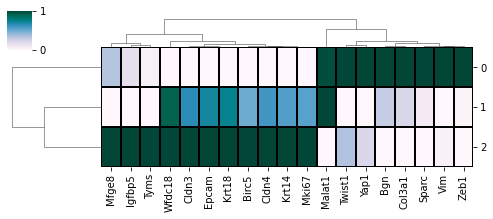

In [1634]:
inds = [list(brca_g_names).index(i) for i in np.unique(new_gs) if i in brca_g_names]

df = pd.DataFrame(np.log10(mean_g[:,inds].T+1))
df.index = brca_g_names[inds]


g=sns.clustermap(df.T,figsize=(7,3),standard_scale=1,cmap="PuBuGn",
               linewidths=0.01,linecolor='black')

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('obsCounts_meKMeans_clustermap_brca.pdf')


In [1635]:
# param_arr[:,brca_sd.gene_names=='Rbfox2',1]

In [ ]:
# mean_g[:,list(brca_g_names).index('Malat1')]

In [ ]:
#0,1,2 --> 1,8,0
#1,0,2 -->8,1,0 (least Malat1)

### **De-$\theta$ Plots**

In [1296]:
def make_fcs(sr,sd,clus1=0,clus2=1,gf_rej=False,thrpars=2,thrmean=1,outlier_de=True,nuc=False,correct_off=False):
    '''
    Utilize different metrics to find fold-changes (FCs) between cluster parameters

    sr: list of SearchResults objects from meK-Means runs
    sd: SearchData object that corresponds to full, input data
    clus1: cluster 1 (to compare FCS of cluster 1/cluster 2 )
    clus2: cluster 2 (to compare FCS of cluster 1/cluster 2 )
    gf_rej: whether to use boolean list of rejected genes from both clusters
    thrpars: FC threshold value (to call DE-theta genes)
    thrmean: Mean S expression threshold value, for genes to consider
    outlier_de: Use iterative outlier calling procedure to assign DE-theta genes (see Monod https://github.com/pachterlab/monod_examples/blob/main/Monod_demo.ipynb)
    nuc: is this nuclear RNA data
    '''

    all_filt_fcs = pd.DataFrame()
    fcs,types,which_pair,highFC,spliceFC,g_names,out_de = ([] for i in range(7))
    
    ind1 = [i for i in range(len(sr)) if clus1 == sr[i].assigns][0]
    ind2 = [i for i in range(len(sr)) if clus2 == sr[i].assigns][0]

    sr1 = sr[ind1]
    sr2 = sr[ind2]
    if correct_off:
        param_names = sr1.model.get_log_name_str()
        offsets = []
        par_vals = np.copy(sr2.param_estimates)
        for k in range(3):
            m1 = sr1.param_estimates[0,:,k]
            m2 = sr2.param_estimates[0,:,k]
            offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
            par_vals[0,:,k] -= offset

        fc_par = (sr1.param_estimates-par_vals)/np.log10(2)
    else:
        fc_par = (sr1.param_estimates-sr2.param_estimates)/np.log10(2)  #Get FCs between cluster params
        
    print('fc_par.shape: ',fc_par.shape)
    if nuc:
        fc_s_par = np.log2(sd.layers[0][:,sr1.filt].mean(1)/sd.layers[0][:,sr2.filt].mean(1))
    else:
        fc_s_par = np.log2(sd.layers[1][:,sr1.filt].mean(1)/sd.layers[1][:,sr2.filt].mean(1)) #Get spliced FCs
        
    print('fc_s_par.shape: ',fc_s_par.shape)

    if outlier_de:
        dr_analysis = monod.analysis.diffexp_pars(sr1,sr2,viz=True,modeltype='id',use_sigma=True)
        par_bool_de = dr_analysis[1].T

    parnames = ('b','beta','gamma')


  #-----is parameter FC significant -----
    if gf_rej is False:
        gf_rej = [True]*sd.n_genes
    else:
        gf_rej = (~sr1.rejected_genes) & (~sr2.rejected_genes)
        
    for n in range(len(parnames)):
        #Boolean for if large param FC and not rejected gene (with minimum expression)
        if nuc:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[0][:,sr1.filt].mean(1)>thrmean) | (sd.layers[0][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej
        else:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[1][:,sr1.filt].mean(1)>thrmean) | (sd.layers[1][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej

        #Boolean for FC (above) but no FC detected at S-level
        gf_highnoise_meanS = gf_highnoise & (np.abs(fc_s_par)<1) & gf_rej

        #Boolean for FC (above)
        gf_onlyhigh = gf_highnoise & gf_rej

        #For dataframe
        fcs += list(fc_par[0,gf_rej,n])
        g_names += list(sr1.gene_names[gf_rej])
        which_pair += [[sr1.assigns,sr2.assigns]]*np.sum(gf_rej)
        highFC += list(gf_onlyhigh[gf_rej])
        spliceFC += list(gf_highnoise_meanS[gf_rej])
        types += [parnames[n]]*np.sum(gf_rej)
        if outlier_de:
            out_de += list(par_bool_de[gf_rej,n])

    if outlier_de:
        all_filt_fcs['deTheta_outlier'] = out_de

    all_filt_fcs['log2FC'] = fcs
    all_filt_fcs['gene'] = g_names
    all_filt_fcs['cluster_pair'] = which_pair
    all_filt_fcs['deTheta_FC'] = highFC
    all_filt_fcs['deTheta_noDeMuS'] = spliceFC
    all_filt_fcs['param'] = types

    return all_filt_fcs


In [552]:
#Get params for each gene, which cluster it marks, and whether it's DE in any param
def get_gene_DE(all_filt_fcs):
    bs = all_filt_fcs[all_filt_fcs.param.isin(['b'])].log2FC
    betas = all_filt_fcs[all_filt_fcs.param.isin(['beta'])].log2FC
    gammas = all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].log2FC
    highFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_FC)
    noSpliceFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_noDeMuS)

    names = all_filt_fcs[all_filt_fcs.param.isin(['b'])].gene

    dom = []
    for i in range(len(noSpliceFCs)):
        fc_b = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].log2FC)[0]
        fc_beta = list(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].log2FC)[0]
        fc_gamma = list(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].log2FC)[0]

        sig_b = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_noDeMuS))[0]
        sig_beta = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_noDeMuS))[0]

        sig_gamma = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_noDeMuS))[0]


        pairs = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].cluster_pair)[0]

# ----- Cell type 'marker' means increase in burst freq,burst,or splicing, or decrease in deg (increased 'stability') ----

        #Increase in burst freq (not outweighted by burst size)
        if (-1*fc_beta > 0 and sig_beta and -1*fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[0]]
            elif (fc_b > 0 and sig_b):
                dom += [pairs[0]]
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta and fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[1]]
            elif (fc_b > 0 and sig_b):
                dom += ['None'] #don't know
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif sig_b:
            if np.abs(fc_b) > np.abs(fc_beta) and np.abs(fc_b) > np.abs(fc_gamma):
                if fc_b > 0:
                    dom += [pairs[0]]
                else:
                    dom += [pairs[1]]            
            elif np.abs(fc_b) < np.abs(fc_beta):
                if fc_beta > 0:
                    dom += [pairs[0]]
                elif fc_beta < 0:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_gamma):
                if fc_gamma < 0:
                    dom += [pairs[0]]
                elif fc_gamma > 0:
                    dom += [pairs[1]]
            else:
                dom += ['None']       
        elif (fc_beta > 0 and sig_beta):
            dom += [pairs[0]]
        elif (fc_gamma > 0 and sig_gamma): #individual FCs
            dom += [pairs[1]]
        elif  (fc_beta < 0 and sig_beta):
            dom += [pairs[1]]
        elif (fc_gamma < 0 and sig_gamma):
            dom += [pairs[0]]
        else:
            dom += ['None']


    return bs,-1*betas,-1*gammas,dom,highFCs,noSpliceFCs,names #-1 for plotting purposes

In [553]:
#Plot FCs of parameters between two clusters

def plot_de(outs,names_plot,mark_plot,xpos,ypos,arrow,assign_colors,figsize=(10,4),betag=False,xlims=[-10,10],fname=None):
    fig,ax = plt.subplots(1,2,figsize=figsize)

    name_inds = [list(outs[6]).index(i) for i in names_plot]

    labs = np.array(outs[3])
    g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[1][labs=='None']),
                      hue=list(pd.Categorical(outs[3])[labs=='None']),
                      palette=assign_colors,ax=ax[0],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                    y=list(outs[1][(labs!='None') &  (outs[5]==False)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None') &  (outs[5]==False)]),
                      palette=assign_colors,ax=ax[0],marker='o',alpha=0.6,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                    y=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                      palette=assign_colors,ax=ax[0],marker='X',alpha=0.8,s=120,edgecolor='black')

    #Annotate genes
    for n in range(len(names_plot)):
        x=list(outs[0])[name_inds[n]]
        y=list(outs[1])[name_inds[n]]
        h=[pd.Categorical(outs[3])[name_inds[n]]]
        if_x=list(outs[5])[name_inds[n]]
        
        if if_x:
            shape = 'X'
        else:
            shape = 'o'
            
        if arrow[n]:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y), fontsize=14,
                           xytext=(x+xpos[n],y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                       arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                         arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",lw=0.4))
        else:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y),fontsize=14,
                           xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    xl =np.asarray([xlims[0],xlims[1]])
    xlx = [xl[0],xl[1]]
    xly = [xl[0],xl[1]]
    ax[0].set_xlim(xlx)
    ax[0].set_ylim(xly)

    ax[0].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

    ax[0].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
    ax[0].set_ylabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
    
    ax[0].tick_params(axis='both', which='major', labelsize=14,)




    if betag == False:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[0])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=100,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")


        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
    else:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[1][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[1])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

                
            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")



        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
        

    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



In [1527]:
def plot_params_order(clus_names, param_vals, genes, sigmas, palette, order=None, title='', figsize=(5,2),fname=None):
    plt.figure(figsize=(figsize))

    if order is None:
        g=sns.stripplot(clus_names,param_vals,hue=genes,palette=palette,s=10,
                      edgecolor='black',alpha=0.8,linewidth=1.0)
    else:
        g=sns.stripplot(clus_names,param_vals,hue=genes,palette=palette,s=10,
                      edgecolor='black',alpha=0.8,order = order,linewidth=1.0)
    
    x_coords = []
    y_coords = []
    for point_pair in g.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)

    if len(sigmas) != 0:
        for x,y in zip(x_coords,y_coords):
            ind = (param_vals==y)
            g.errorbar(x,y,yerr=np.array(sigmas)[ind]*2.576,
                         ecolor='black',alpha=0.4,linewidth=2,ls='none')

    
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.tick_params(axis='both', which='major', labelsize=14,)
    plt.title(title)
    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)
        


Looking at all chosen sr results

Need to:
1. Reject genes with poor fits
2. Plot DE genes between populations of interest

In [530]:
import re

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


./fits/explorData_0313/gg_240312_025_brca1_K15_1


/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4156: RuntimeWarning: invalid value encountered in multiply
  return fac1 * sc.k1e(a * sq) * np.exp(b*x - a*sq) / sq
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/st

./fits/explorData_0313/gg_240312_025_pbmc_K10_1


/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns

./fits/explorData_0313/gg_240312_025_e11e13_K5_1


/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: Runtime

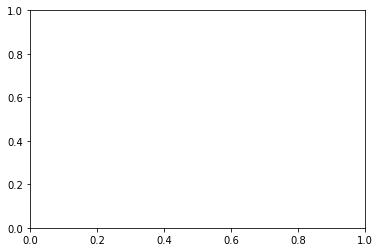

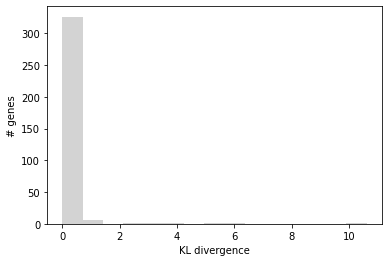

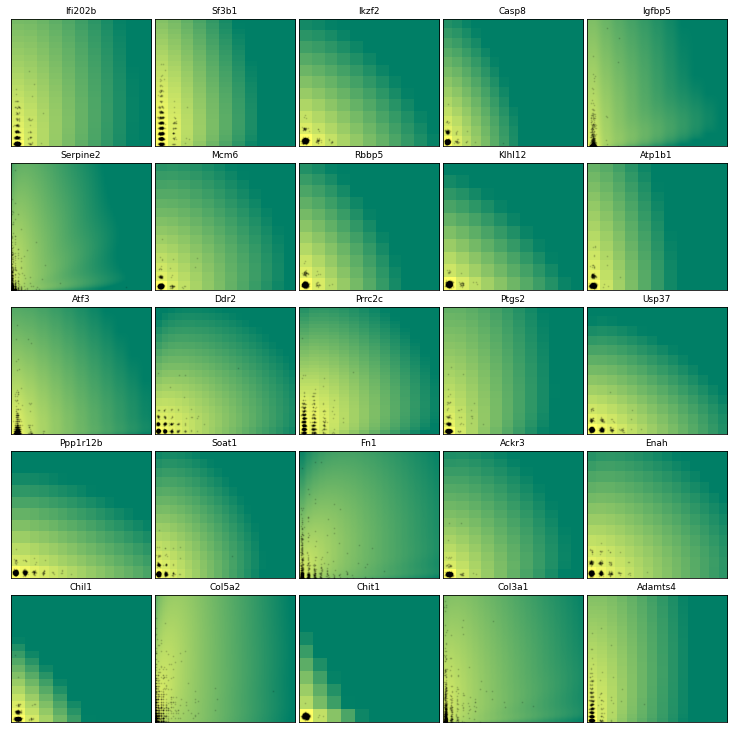

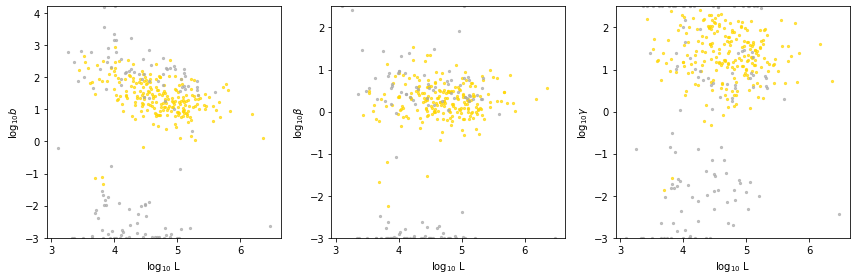

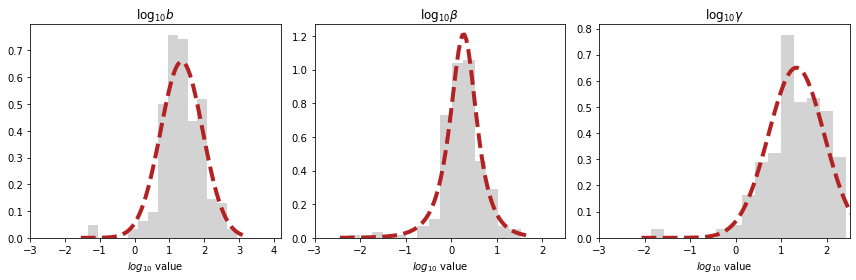

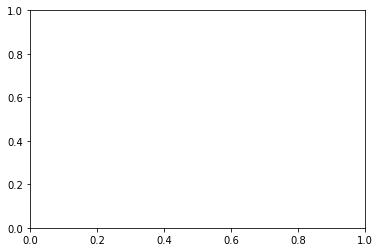

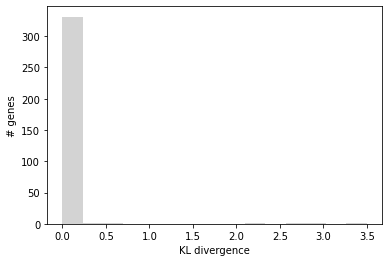

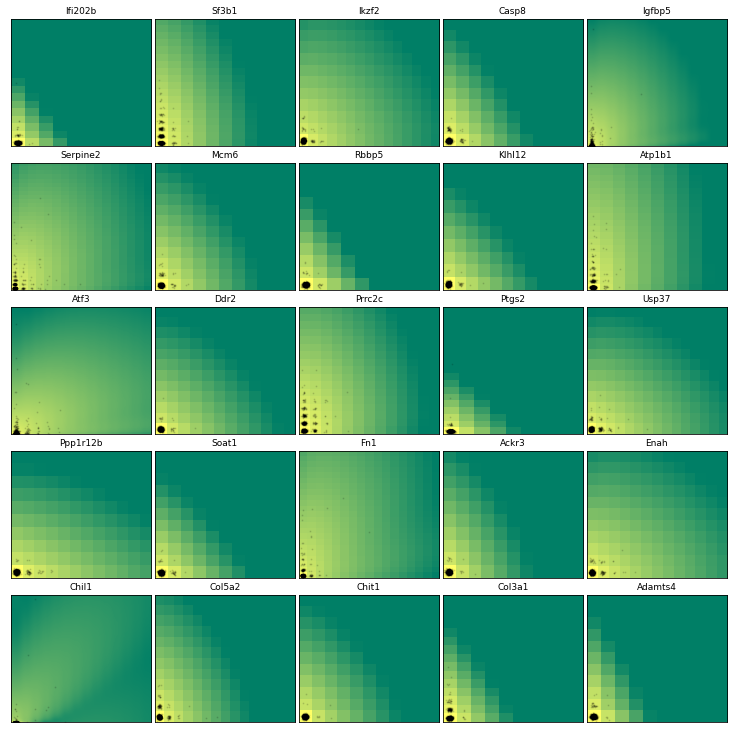

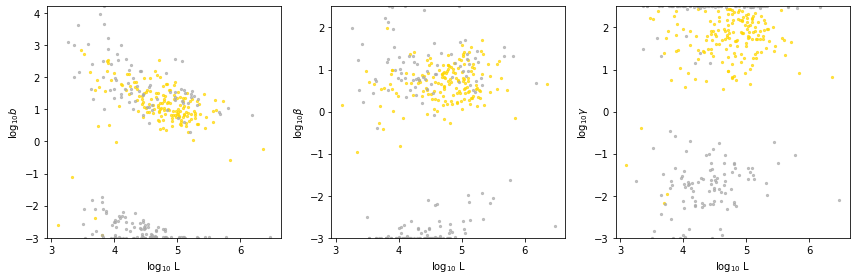

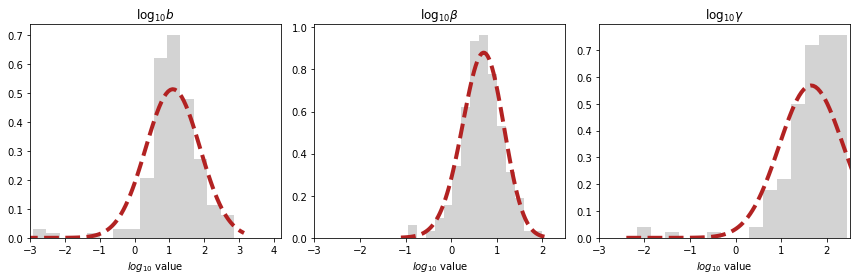

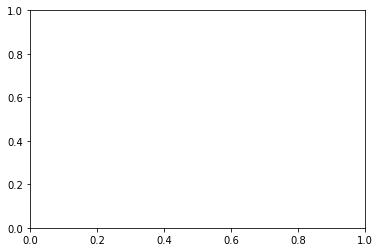

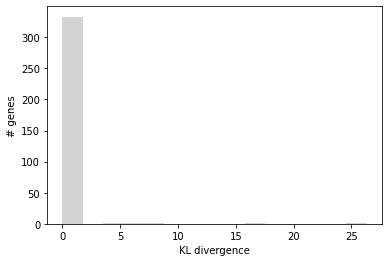

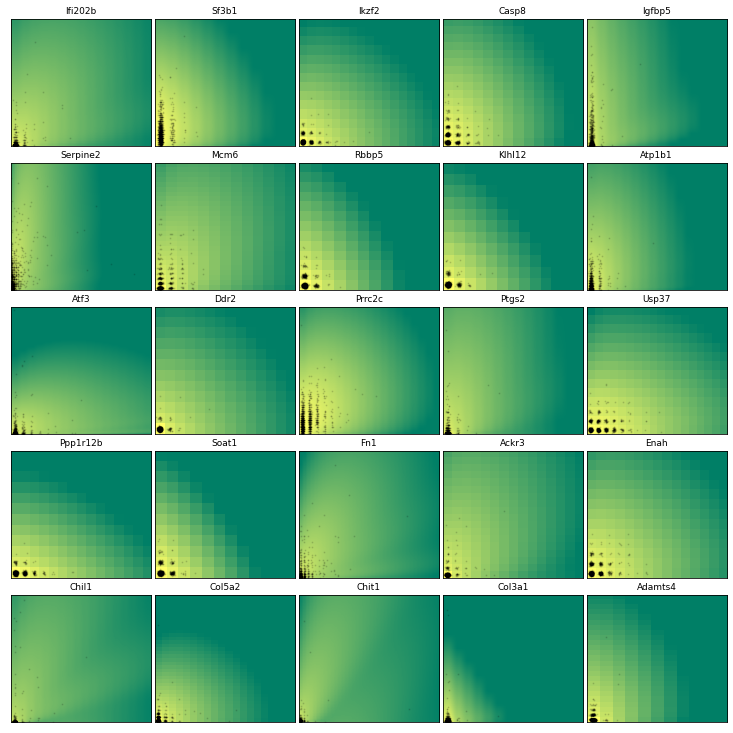

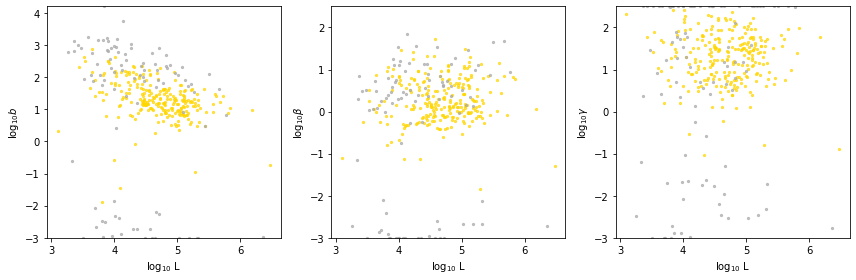

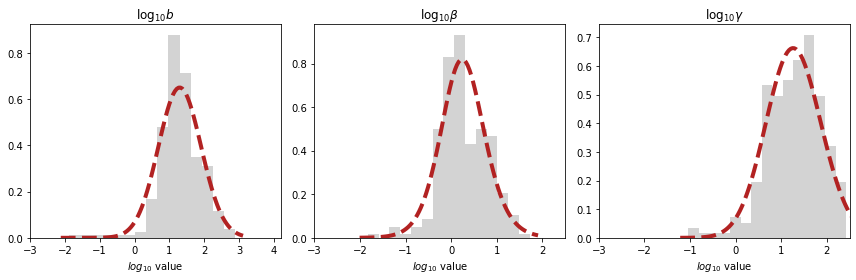

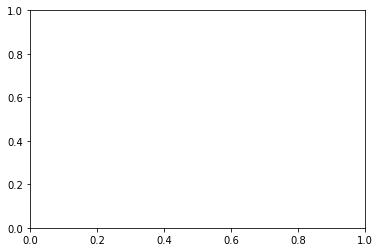

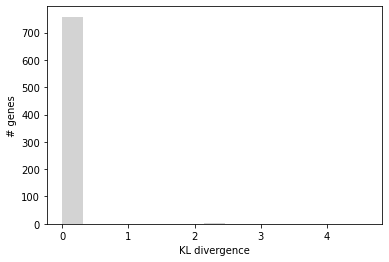

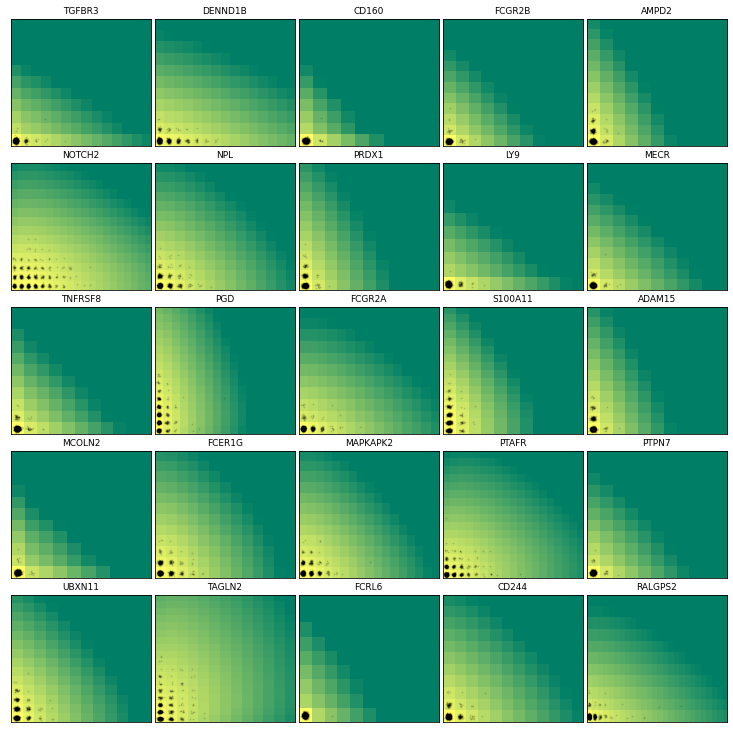

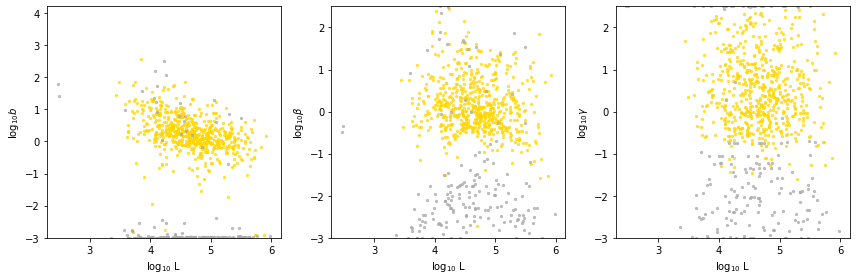

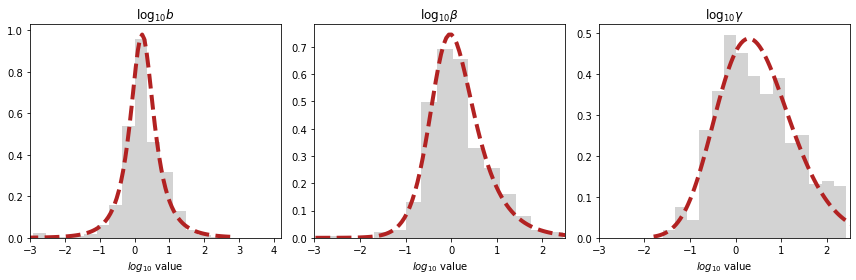

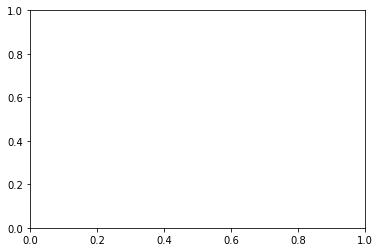

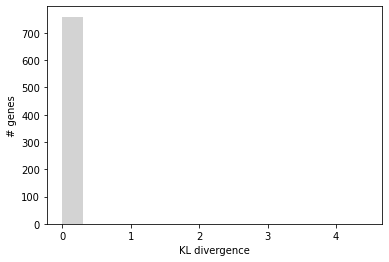

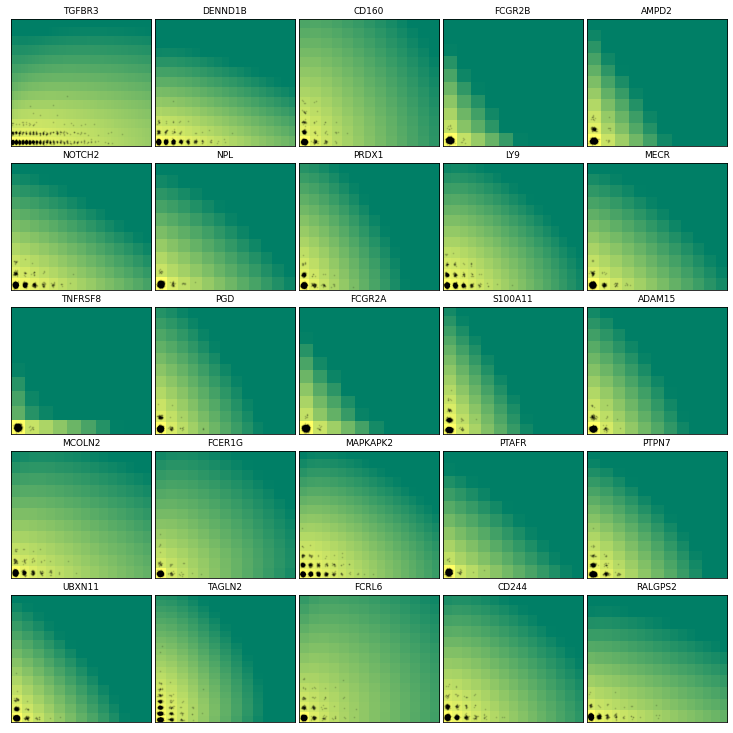

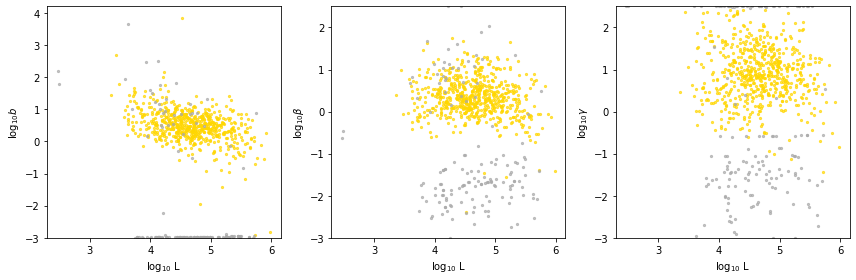

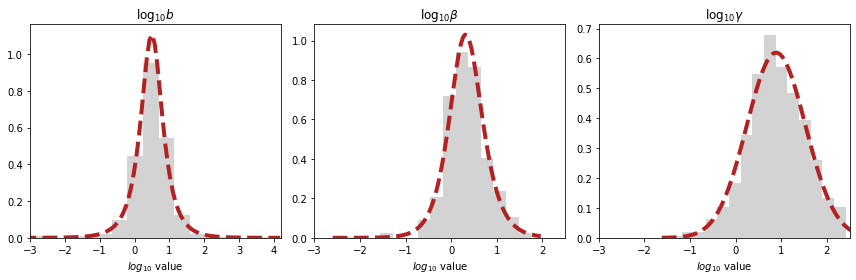

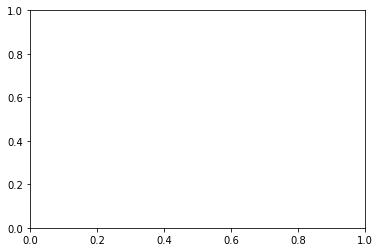

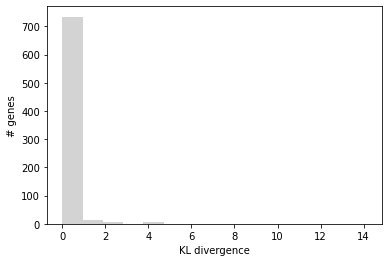

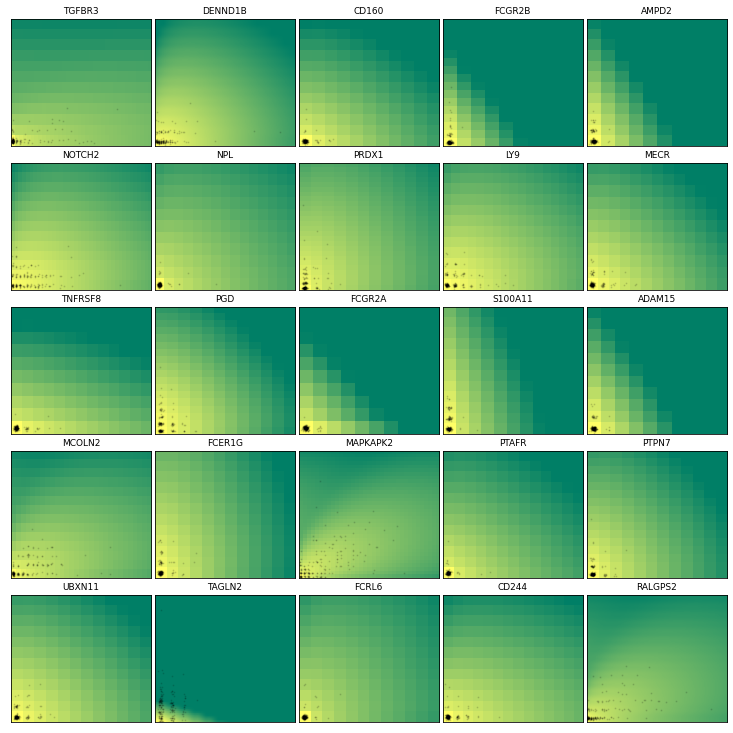

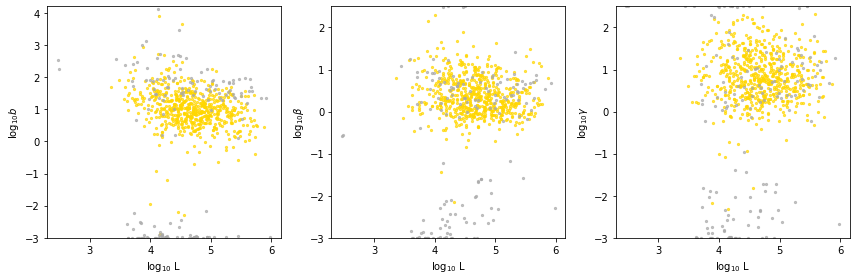

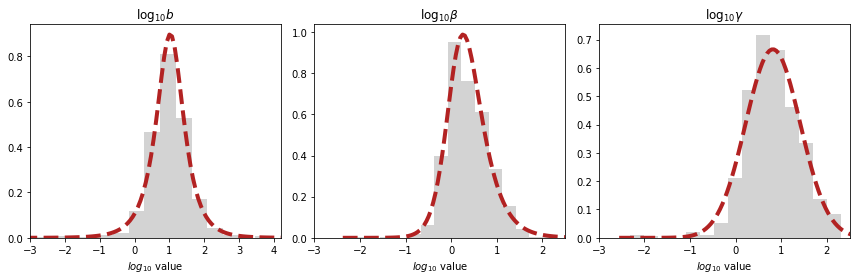

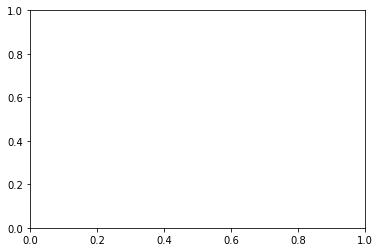

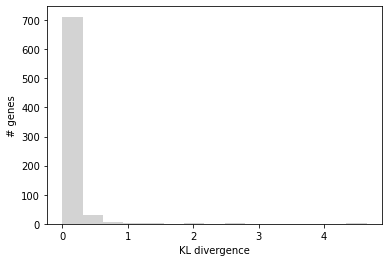

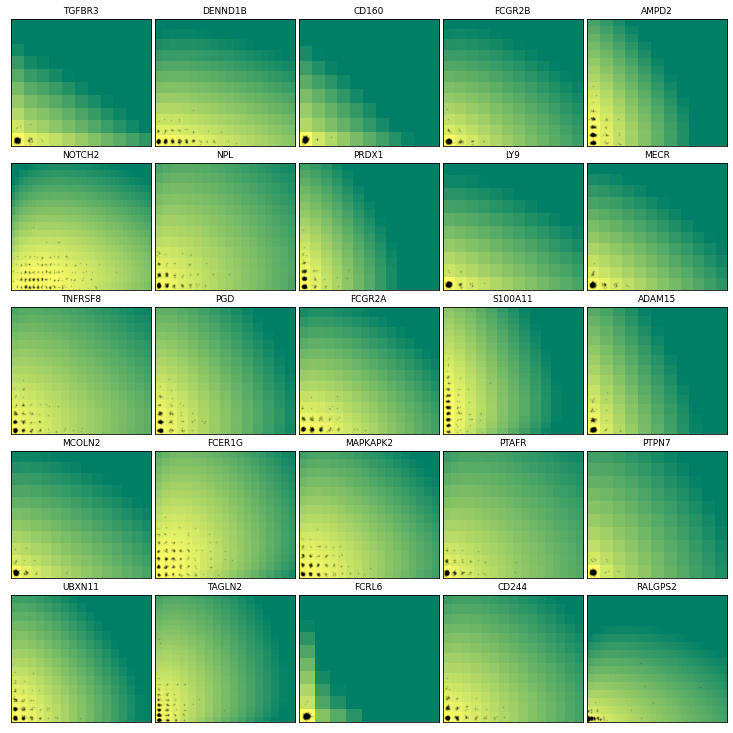

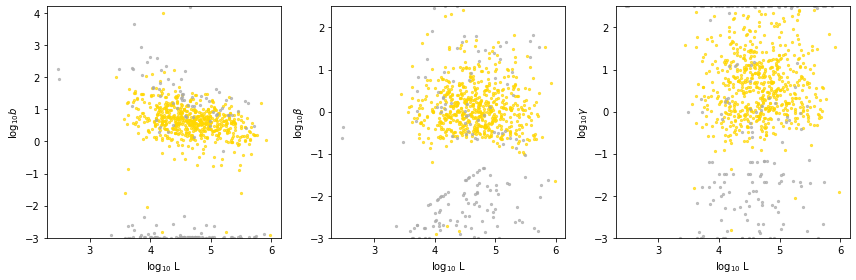

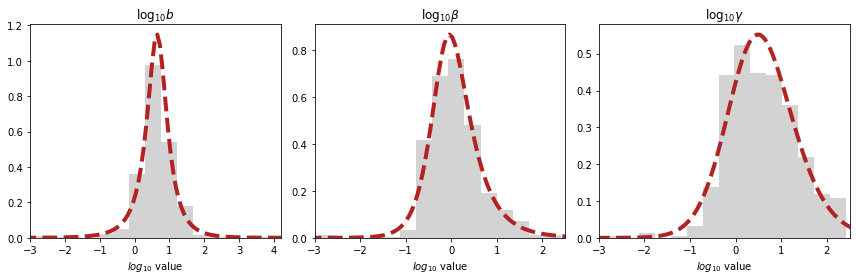

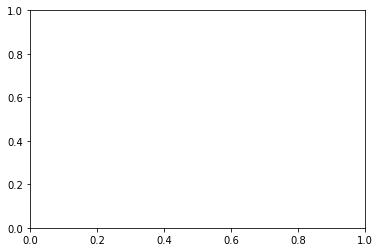

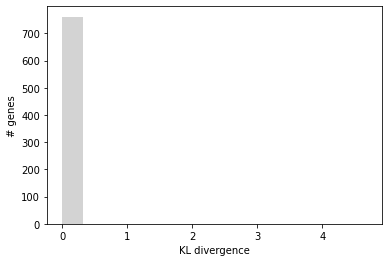

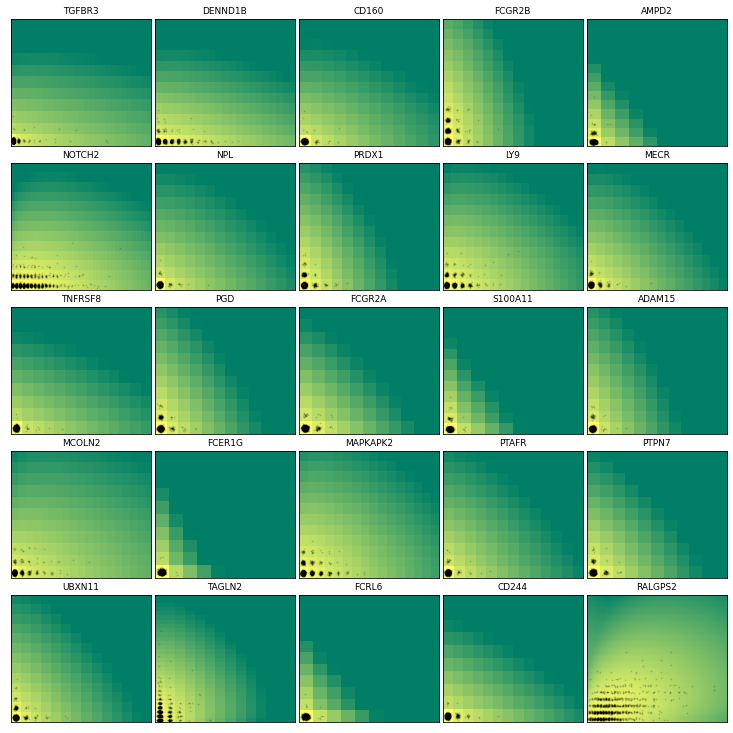

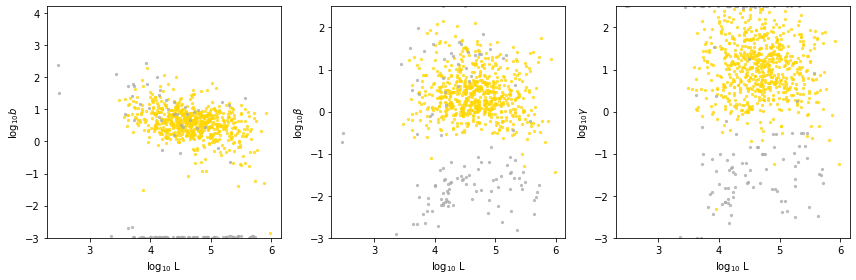

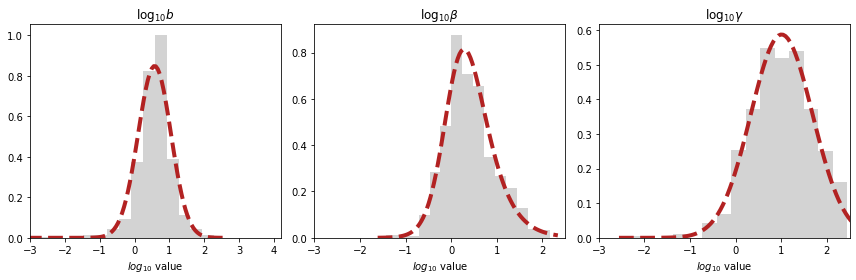

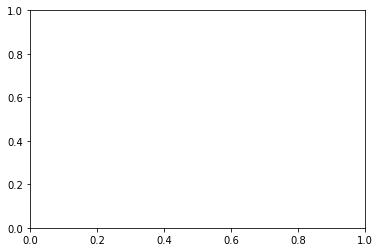

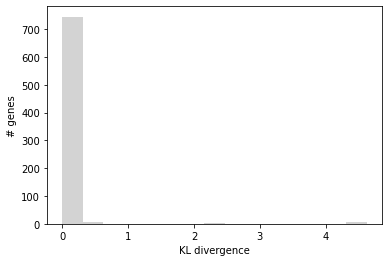

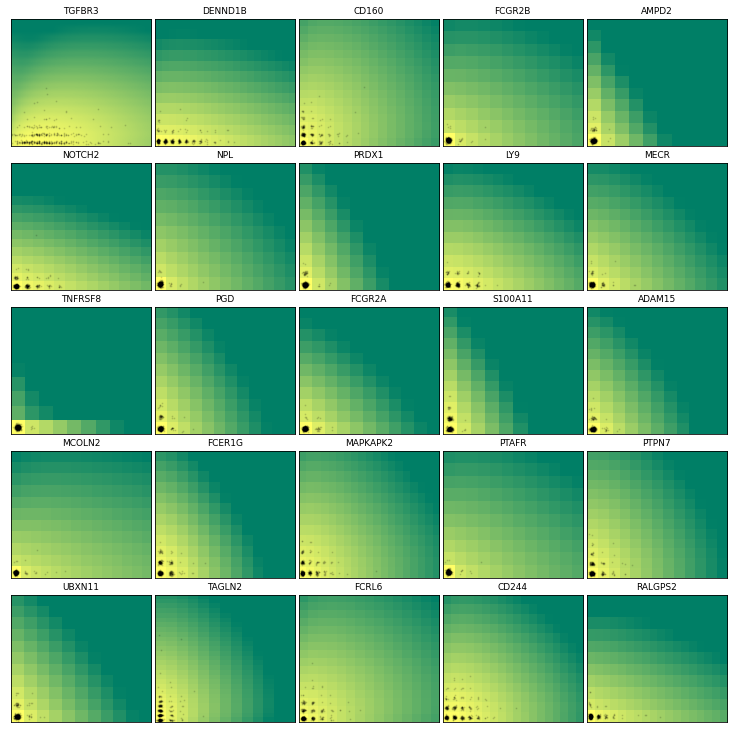

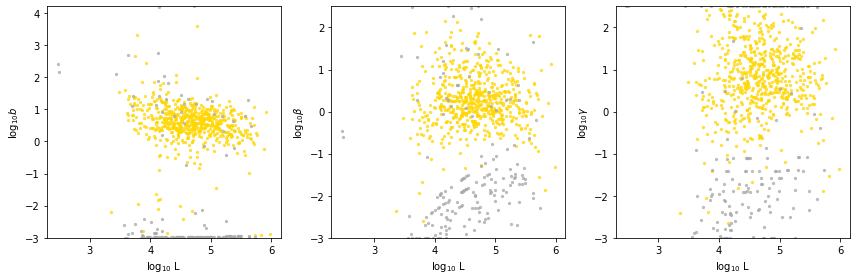

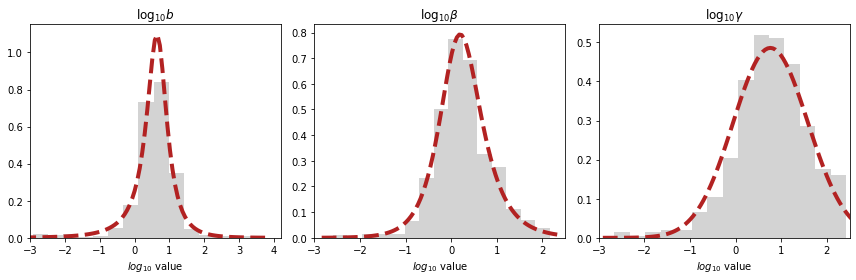

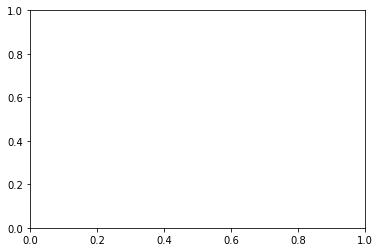

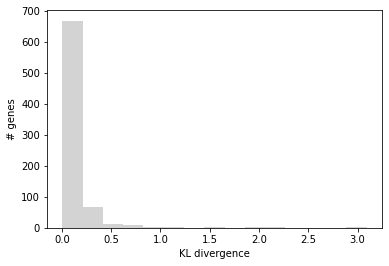

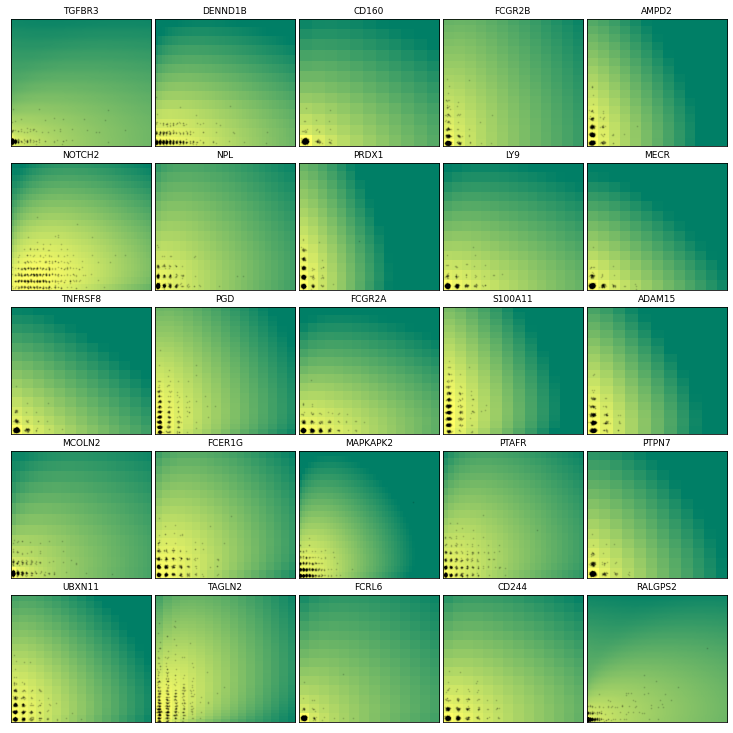

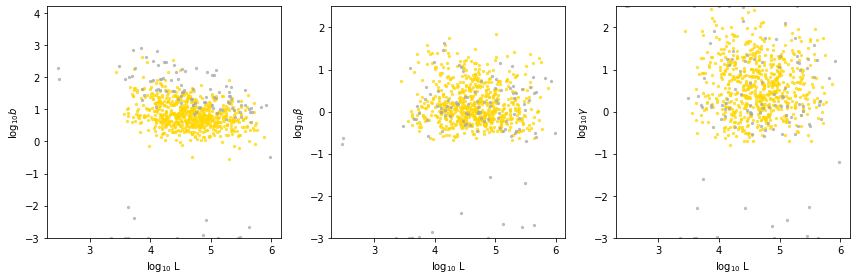

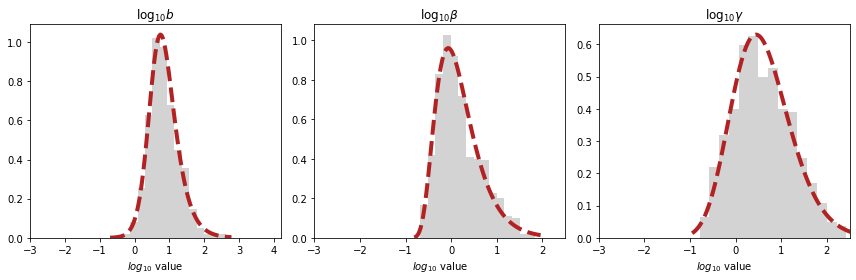

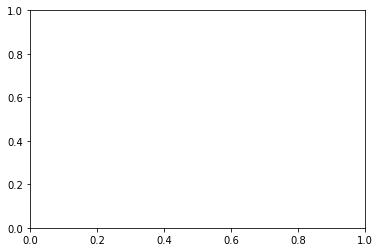

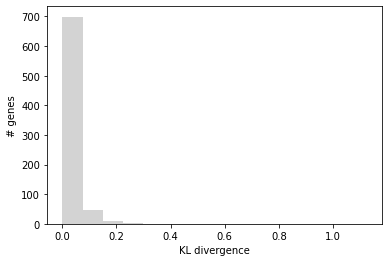

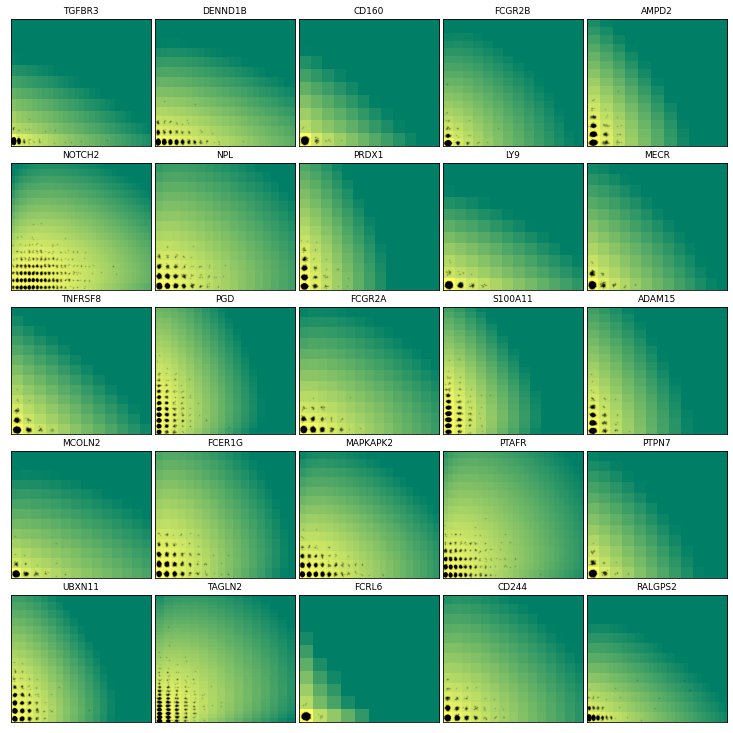

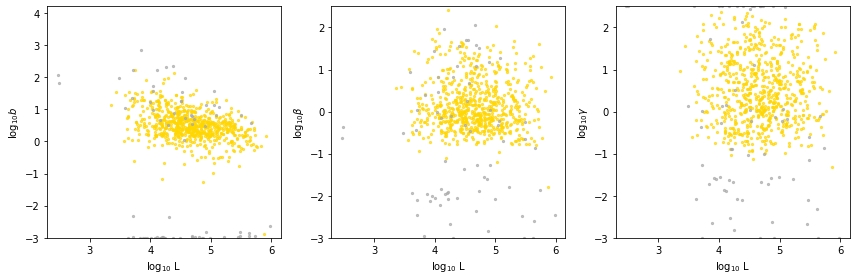

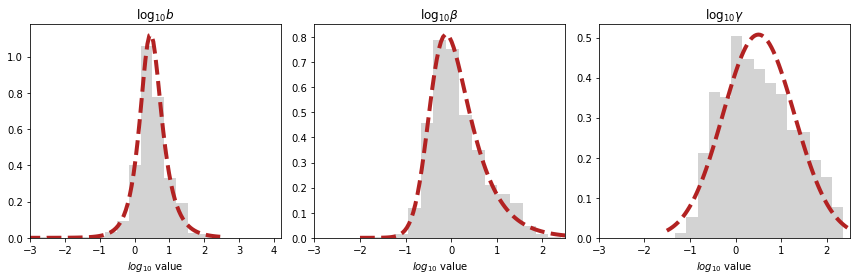

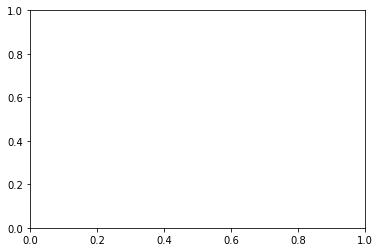

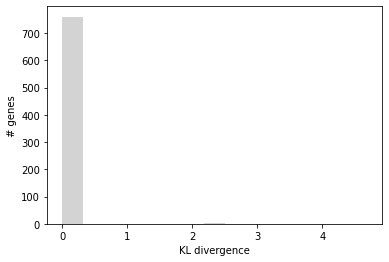

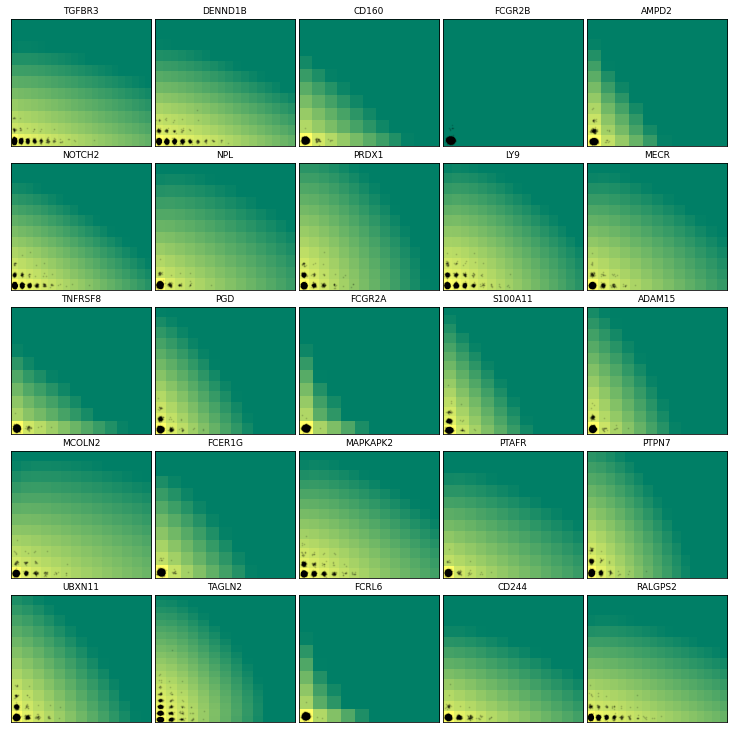

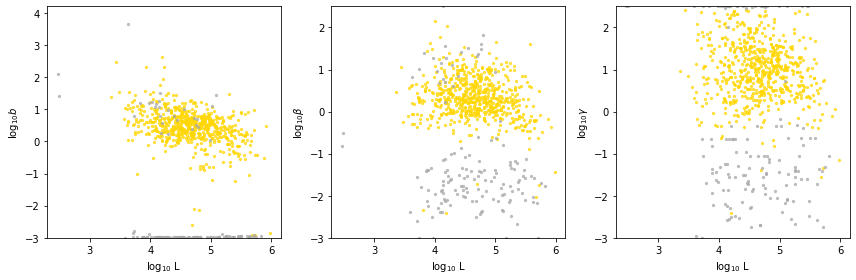

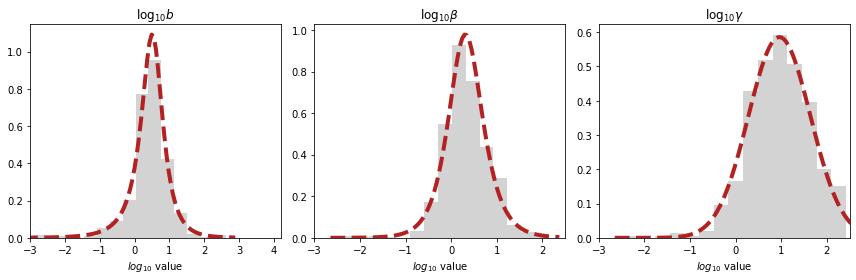

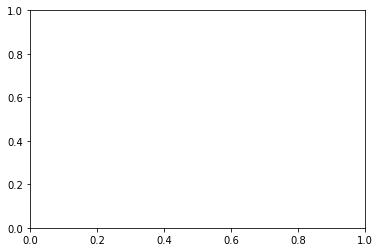

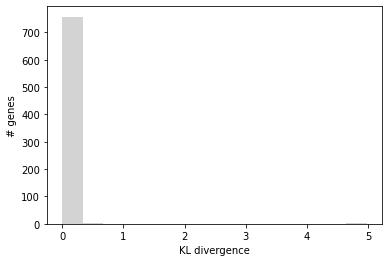

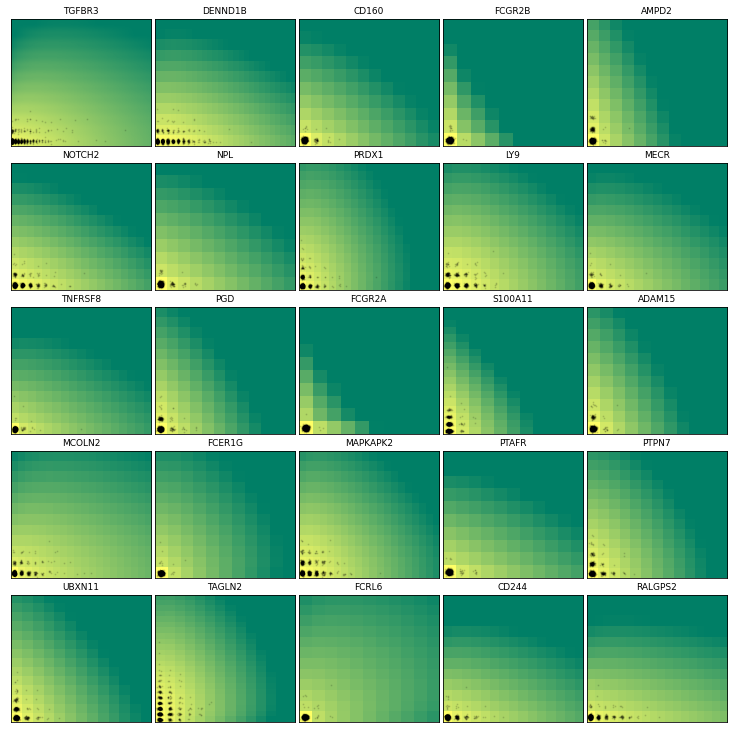

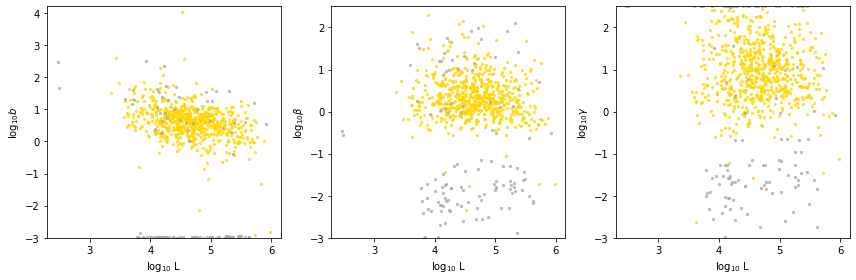

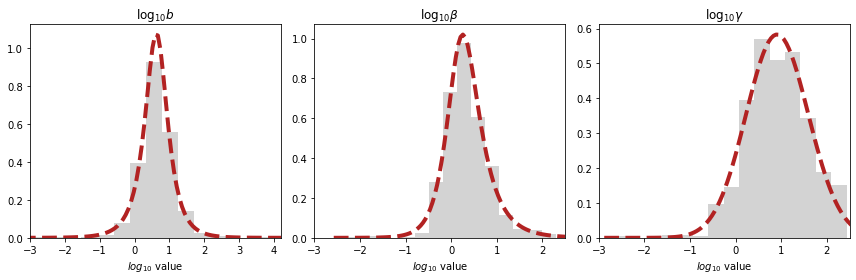

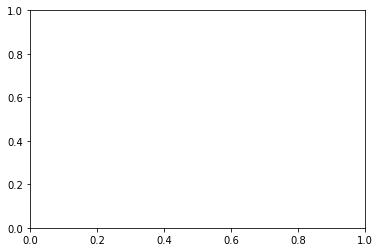

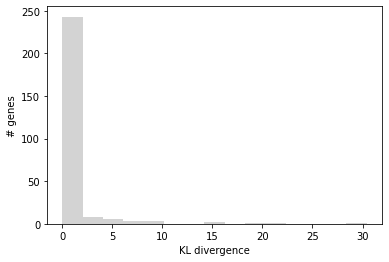

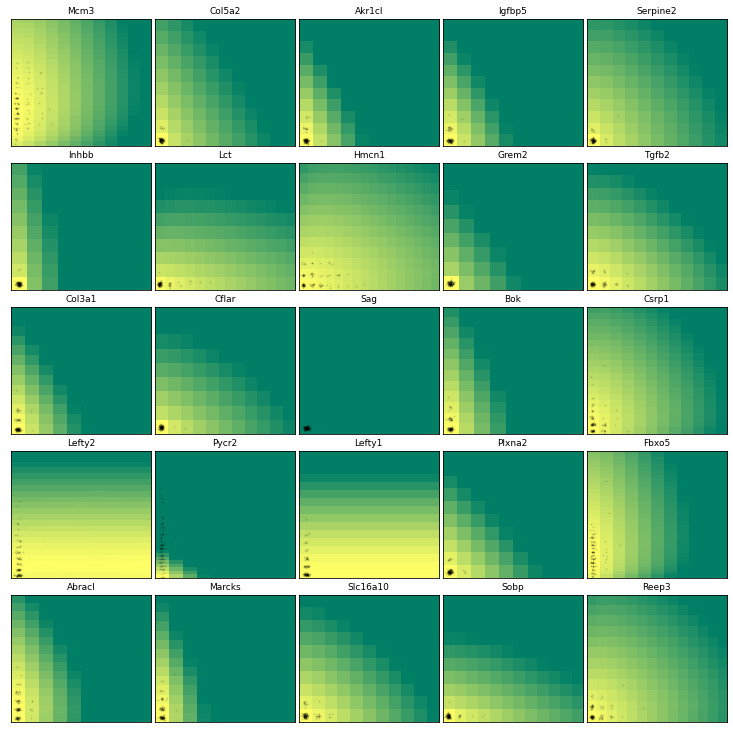

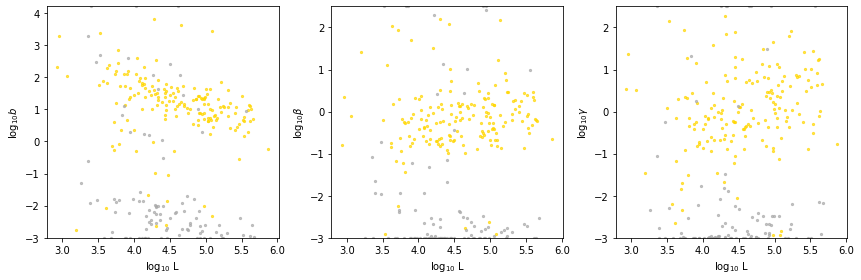

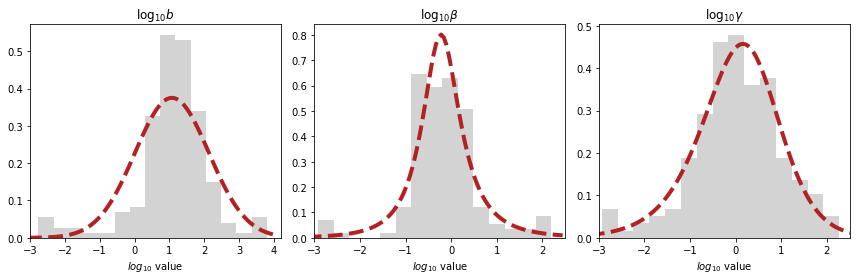

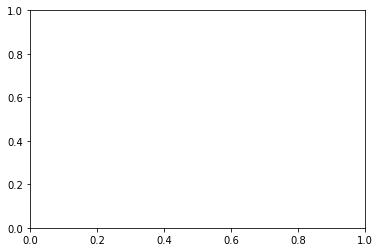

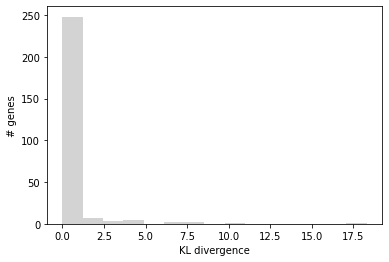

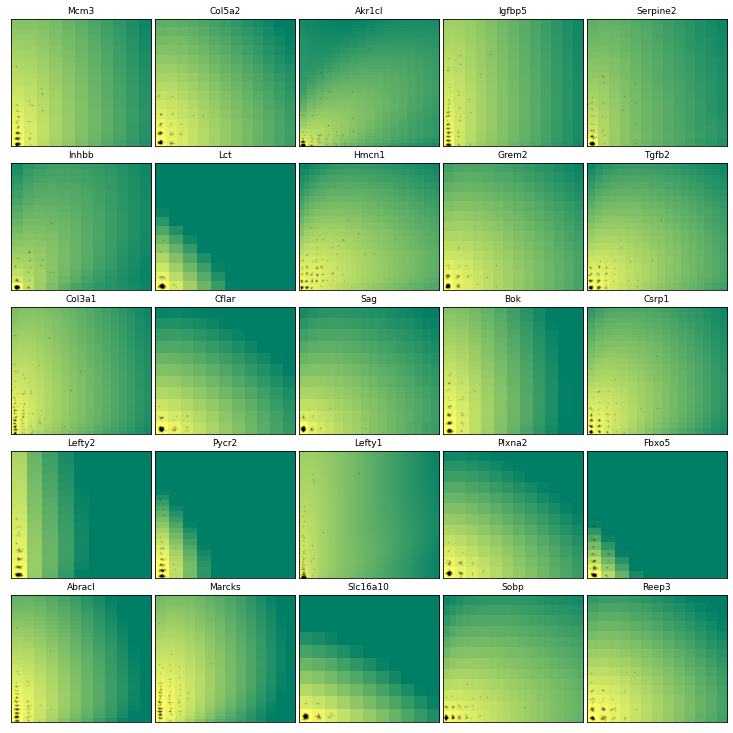

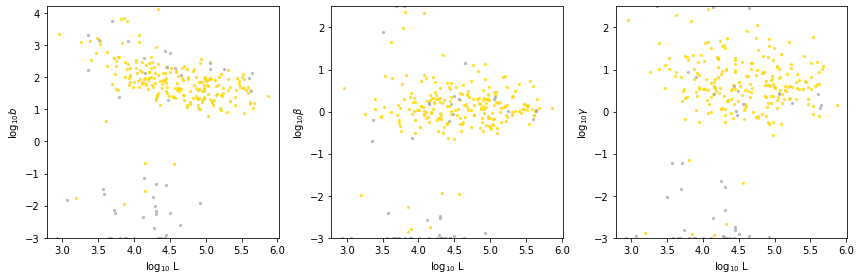

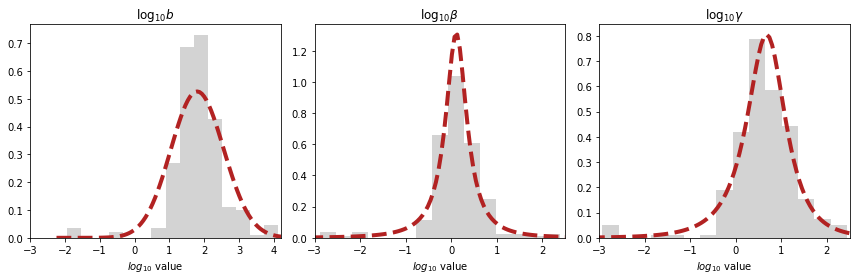

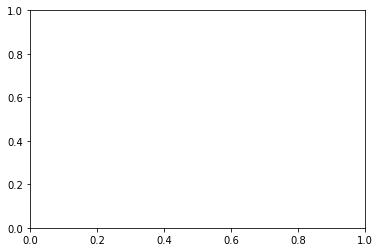

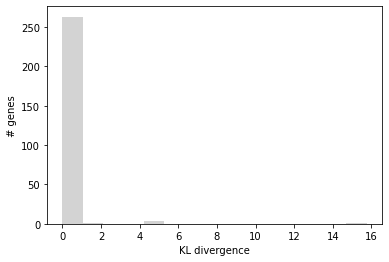

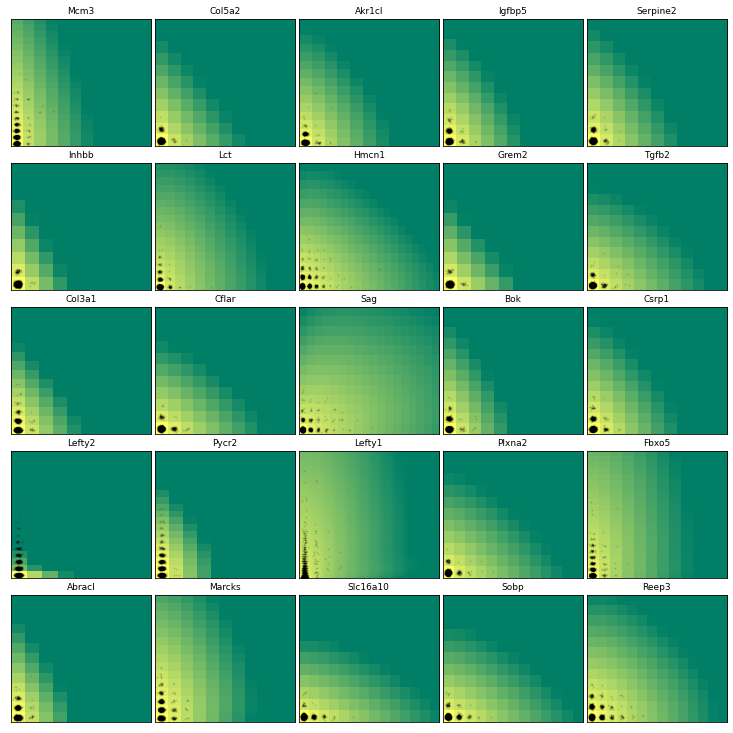

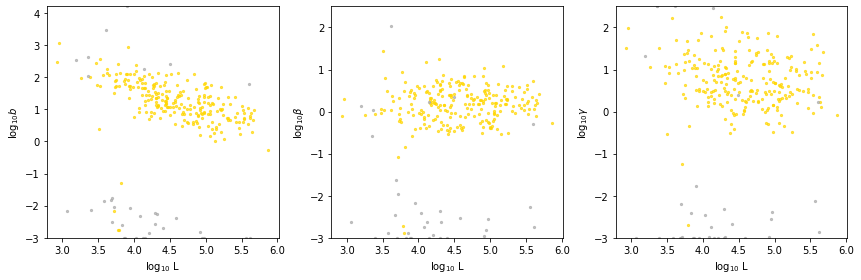

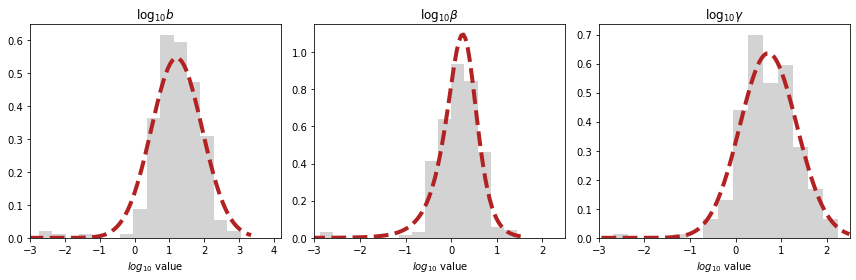

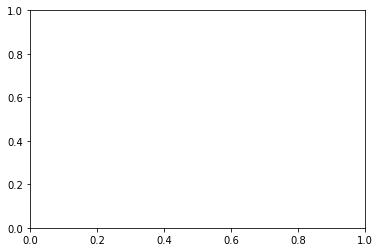

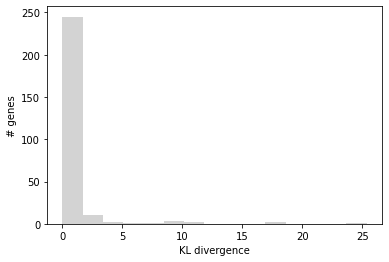

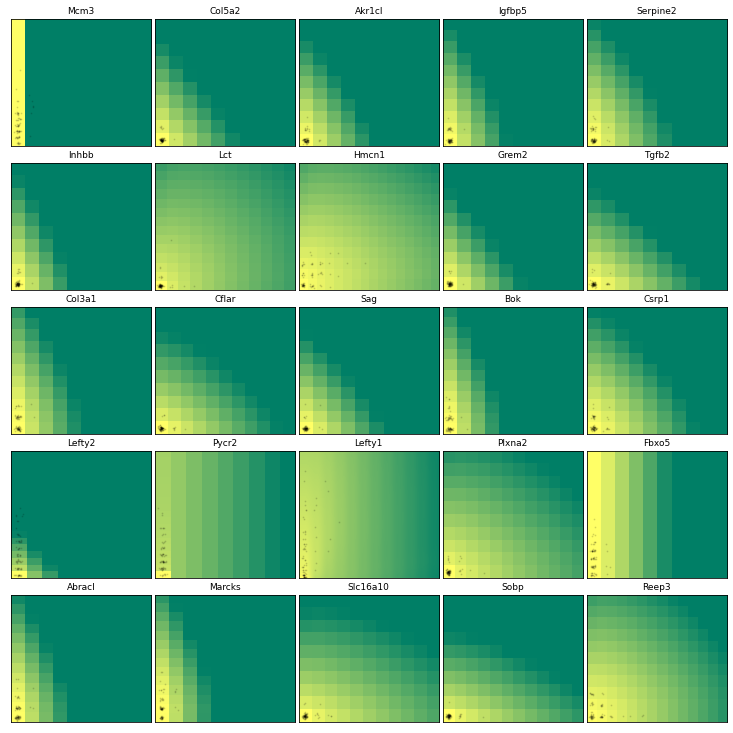

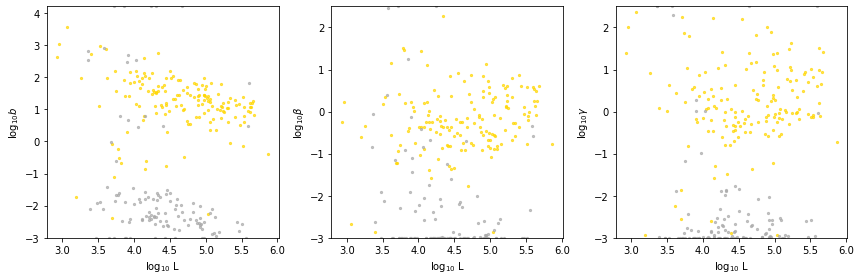

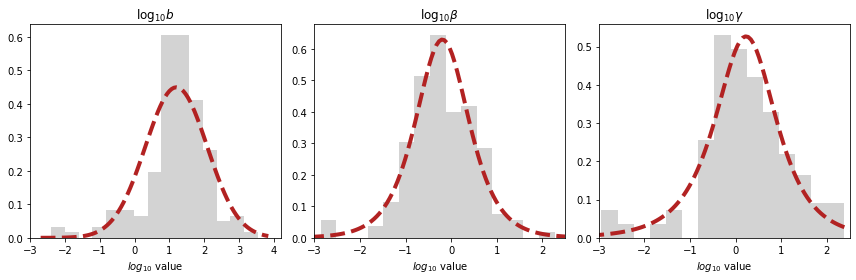

In [536]:
#Run gene rejection statistics
result_strings_ofinterest = np.array(result_strings)[chosen_inds]

for i in range(len(chosen_inds)):
    dash_inds = [m.start() for m in re.finditer('/', result_strings_ofinterest[i][0])]
    dir_string = result_strings_ofinterest[i][0][:dash_inds[3]]
    print(dir_string)

    for r in chosen_sr[i]:

        fig1,ax1 = plt.subplots(1,1)
        r.find_sampling_optimum() #There is only one set of sampling parameters

        fig1,ax1 = plt.subplots(1,1)
        r.plot_KL(ax1)
        r.plot_gene_distributions(chosen_sd[i][0],marg='joint')

        _=r.chisquare_testing(chosen_sd[i][0],threshold=1e-3) #Chi-sq rejection testing
        r.chisq_best_param_correction(chosen_sd[i][0],Ntries=4,viz=False,threshold=1e-3) 

        r.compute_sigma(chosen_sd[i][0],num_cores=40) #Sigma, std error calcs
        r.plot_param_L_dep(plot_errorbars=False,plot_fit=True) #Check if burst length-dep exists
        r.plot_param_marg()

        monod.analysis.make_batch_analysis_dir([r],dir_string)
        r.update_on_disk()

In [534]:
result_strings_ofinterest[1]

['./fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_2.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_7.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_1.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_9.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_3.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_4.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_5.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_8.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_0.res',
 './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_6.res']

In [545]:
result_strings_upd = []
for i in result_strings_ofinterest: 
    result_strings_upd += [[glob.glob(m[:-4]+'_upd.res')[0] for m in i]]
    
sr_all = [] #SearchResults for each dataset
for strings in result_strings_upd:
    sr_all += [[monod.analysis.load_search_results(i) for i in strings]]

len(sr_all)

3

**Germ cells**

In [1637]:
#Set colors for 10 clusters
#9FD69F E13 0 
#CEC2DE E11 1
pal =['teal','rosybrown','lemonchiffon','lightsteelblue','wheat'] #Accent hex colors
assign_colors = dict(zip(range(len(pal)),pal))
assign_colors['None'] = 'lightgrey'

In [1605]:
#Ccnd3, Bnc2, Nanog, 
germ_de = ['Ccnd3','Bnc2','Nanog','Tbrg4','Rbm38','Supt6','Dmrt1','Grem2','Bmp2',
          'Inhbb','Fst','Dazl', 'Ddx4', 'Mael',
          'Lefty1','Lhx1','Otx2','Stra8','Sycp3','Dmc1','Meoic','Smc1b',
          'Gata2', 'Id1', 'Id2', 'Id3', 'Cdx2', 'Smad6', 'Dlx3', 'Msx1','Msx2' ]
e13_de = ['Pabpc1','Lsm8','Cdc40','Zrs1','Snrnp27','Rbm17','Supt5','Ddx5','Cir1','Srrm2',
         'Ddx41','Aqr','Pdcd11','Dhx8','Srek1']

In [1606]:
# for r in sr_all[2]:
#     print(r.assigns)
#     print(r.param_estimates[0,chosen_sd[2][0].gene_names=='Bnc2',1])

fc_par.shape:  (1, 268, 3)
fc_s_par.shape:  (268,)


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


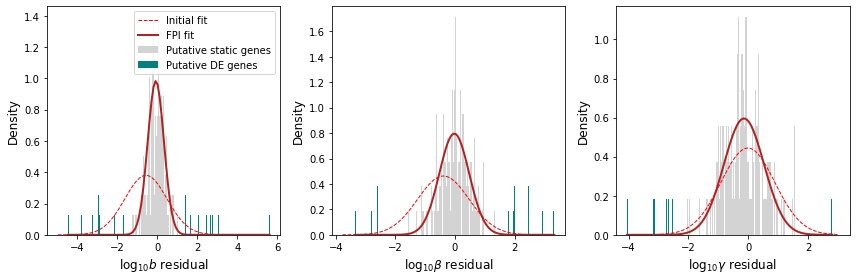

In [1607]:
#Compare  0 vs 1 (E13 vs E11)
all_filt_fcs = make_fcs(sr_all[2],chosen_sd[2][0],clus1=4,clus2=1,
                gf_rej=True,thrpars=2,thrmean=0.1,outlier_de=True,nuc=False,correct_off=True)

In [1608]:
all_filt_fcs[all_filt_fcs['gene'].isin(germ_de+list(germ_markers)+e13_de)  & all_filt_fcs['deTheta_FC'].isin([True])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
7,True,-21.445091,Lefty2,"[4, 1]",True,False,b
8,False,-5.432078,Lefty1,"[4, 1]",True,False,b
21,False,-2.916726,Nr2c1,"[4, 1]",True,False,b
24,False,-2.112073,Hormad2,"[4, 1]",True,True,b
46,True,-11.633132,Msx2,"[4, 1]",True,False,b
60,False,-2.435826,Ccnd3,"[4, 1]",True,False,b
63,False,-3.485272,Pbx3,"[4, 1]",True,True,b
73,True,6.984359,Spo11,"[4, 1]",True,False,b
82,False,-4.068684,Hormad1,"[4, 1]",True,False,b
83,False,-3.469431,Lef1,"[4, 1]",True,False,b


In [1609]:
# all_filt_fcs[all_filt_fcs['deTheta_noDeMuS'].isin([True])]

In [1610]:
out_marks = get_gene_DE(all_filt_fcs)

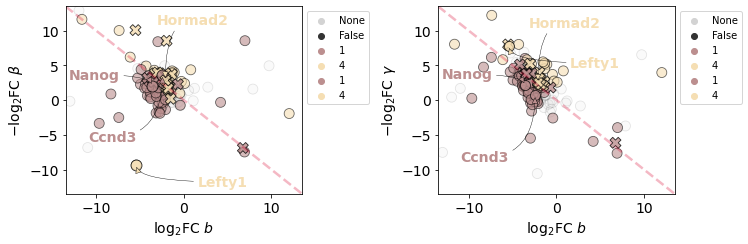

In [1611]:
names_plot = ['Ccnd3','Nanog','Lefty1','Hormad2'] #Tpm1 age-related https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8225046/
mark_plot = [1,1,4,4]
xpos = [-8.5,-9.5,7,-1]
ypos = [-9.5,1,-3,8]
arrow = [True,True,True,True]

plot_de(out_marks,names_plot ,mark_plot,xpos,ypos,arrow,
        assign_colors,figsize=(10.5,3.5),fname='germ_E13vsE11.pdf',xlims=[-13.5,13.5])

In [1316]:
# #Compare  0 vs 1 (E13 vs E11)
# all_filt_fcs = make_fcs(sr_all[2],chosen_sd[2][0],clus1=0,clus2=3,
#                 gf_rej=True,thrpars=2,thrmean=0.1,outlier_de=True,nuc=False)

In [1280]:
ds = lp.connect(chosen_loom[2])
true_labs = ds.ca['subclass_label']
ds.close()

In [1317]:
#Find example of increasing splicing over clusters
order = [1,0,3,4]
o_inds = []
o_sr = sr_all[2]
for o in order:
    o_inds += [[i for i in range(len(o_sr)) if o == o_sr[i].assigns][0]]
o_inds

[0, 3, 1, 2]

In [1380]:
#Find example of increasing splicing over clusters
par_vals_g1 = np.copy(sr_all[2][0].param_estimates)
par_vals_g3 = np.copy(sr_all[2][1].param_estimates)
par_vals_g4 = np.copy(sr_all[2][2].param_estimates)
par_vals_g0 = np.copy(sr_all[2][3].param_estimates)

param_names = sr_all[2][3].model.get_log_name_str()

for k in range(3):
    m1 = par_vals_g1[0,:,k]
    m2 = par_vals_g3[0,:,k]
    offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
    par_vals_g3[0,:,k] -= offset
    
    
    m2 = par_vals_g4[0,:,k]
    offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
    par_vals_g4[0,:,k] -= offset
    
    
    m2 = par_vals_g0[0,:,k]
    offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
    par_vals_g0[0,:,k] -= offset

beta1 = par_vals_g1[0,:,1]
beta2 = par_vals_g0[0,:,1]
beta3 = par_vals_g3[0,:,1]
beta4 = par_vals_g4[0,:,1]

greater_betas = np.where((beta1<beta4))

print(chosen_sd[2][0].gene_names[greater_betas])

['Mcm3' 'Akr1cl' 'Igfbp5' 'Tgfb2' 'Sag' 'Lefty1' 'Plxna2' 'Fbxo5' 'Marcks'
 'Nfic' 'Cnn2' 'Timp3' 'Cd63' 'Tbrg4' 'Anxa6' 'Sparc' 'Thra' 'Zfp36l1'
 'Rrm2' 'Tdrd9' 'Crip1' 'Gmnn' 'Aggf1' 'Map1b' 'Parp8' 'Tgfbi' 'Gata4'
 'Dpysl2' 'Rgcc' 'Wnt5a' 'Dab2' 'Uhrf1' 'Dagla' 'Rnd3' 'Nr4a2' 'Nsmf'
 'Angptl2' 'Bbs5' 'Klhl23' 'Wt1' 'B2m' 'Slc24a3' 'Myl9' 'Nnat' 'Tox2'
 'Tshz2' 'Gucy1b1' 'Ccn1' 'Usp13' 'Jun' 'L1td1' 'Echdc2' 'Tyms' 'Lrpap1'
 'Msx1' 'Ldb2' '5430416N02Rik' 'Taf6' 'Pdgfra' 'Fscn1' 'Tuba3a' 'Col1a2'
 'Mest' 'Stra8' 'Lockd' 'Capns1' 'Aldh16a1' 'Ccdc155' 'Nr2f2' 'Arnt2'
 'Usp35' 'Mki67' 'Tshz3' 'Ldha' 'Wee1' 'Ppp1ccb' 'Sez6l2' 'Ptpre' 'Col4a1'
 'Junb' 'Cdh11' 'Piwil4' 'Ncam1' 'Acsbg1' 'Smad6' 'Aldh1a2' 'Trank1'
 'Itga9' 'Smarca1' 'Rbmx' 'Hcfc1' 'Taf7l' 'Nxf2' 'Mtmr1' 'Ar']


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


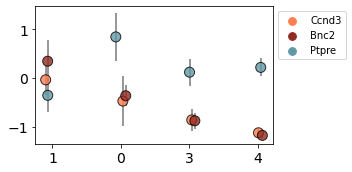

In [1456]:
#plot Splicing (beta/k) over germ cell clusters, Mki67,5430416N02Rik. 


betas = []
sr_x = []
genes_names = []
sigmas = []

#prop_e13 = []
expr_mature = []

ds = lp.connect(chosen_loom[2])
true_labs = ds.ca['subclass_label']
ds.close()

for g in ['Ccnd3','Bnc2','Ptpre']:
    for r,o,true_o in zip([beta1,beta2,beta3,beta4],order,o_inds):
        betas += [r[chosen_sd[2][0].gene_names==g][0]]
        sr_x += [o]

        #prop_e13 += [np.sum(true_labs[sr_all[2][true_o].filt]=='170726_T_E13')/len(true_labs[sr_all[2][true_o].filt])]
        
        genes_names += [g]

        sigmas += [sr_all[2][true_o].sigma[chosen_sd[2][0].gene_names==g,1][0]]

plot_params_order(sr_x, betas, genes_names,sigmas, 
                  palette={'Ccnd3':'#FF7F50','Dmrt1':'#922B21','Bnc2':'#922B21','Ptpre':'#6299a5'},
                  order=order,
                  title='',
                  figsize=(5,2.5),fname='germ_splice_genes_stages.pdf')

In [1565]:
#plot Splicing (beta/k) over germ cell clusters, Mki67,5430416N02Rik. 


sr_x = []
genes_names = []

#prop_e13 = []
expr_mature = []

ds = lp.connect(chosen_loom[2])
true_labs = ds.ca['subclass_label']
ds.close()

for g in ['Nanog','Nanos2','Piwil4']:
    for r in sr_all[2]:
        expr_mature += list(chosen_sd[2][0].layers[1][chosen_sd[2][0].gene_names==g,r.filt]) #Do expression instead
        sr_x += [r.assigns]*len(list(chosen_sd[2][0].layers[1][chosen_sd[2][0].gene_names==g,r.filt]))

        #prop_e13 += [np.sum(true_labs[sr_all[2][true_o].filt]=='170726_T_E13')/len(true_labs[sr_all[2][true_o].filt])]
        
        genes_names += [g]*len(list(chosen_sd[2][0].layers[1][chosen_sd[2][0].gene_names==g,r.filt]))


mature_df = pd.DataFrame()
mature_df['Expr'] = expr_mature
mature_df['Cluster'] = sr_x 
mature_df['Gene'] = genes_names
mature_df.head()

,Expr,Cluster,Gene
0,6,1,Nanog
1,3,1,Nanog
2,6,1,Nanog
3,1,1,Nanog
4,0,1,Nanog


<AxesSubplot:xlabel='Cluster', ylabel='Expr'>

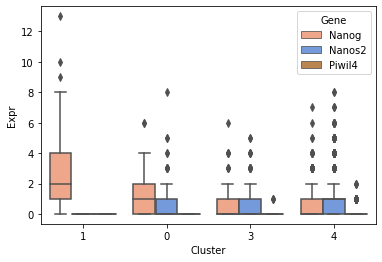

In [1566]:
#mature_df['Expr'] = np.log1p(mature_df['Expr'])
sns.boxplot(data=mature_df,x='Cluster',y='Expr',hue='Gene',palette={'Nanog':'lightsalmon','Nanos2':'cornflowerblue',
                                                                   'Piwil4':'peru'},
           order=order)


In [1570]:
#plot Splicing (beta/k) over germ cell clusters, Mki67,5430416N02Rik. 
sr_x = []
genes_names = []

#prop_e13 = []
expr_mature = []

ds = lp.connect(chosen_loom[2])
true_labs = ds.ca['subclass_label']
ds.close()

for g in ['Nanog','Nanos2','Piwil4']:
    for r in sr_all[2]:
        expr_mature += [np.mean(chosen_sd[2][0].layers[1][chosen_sd[2][0].gene_names==g,r.filt])] #Do expression instead
        sr_x += [r.assigns]

        #prop_e13 += [np.sum(true_labs[sr_all[2][true_o].filt]=='170726_T_E13')/len(true_labs[sr_all[2][true_o].filt])]
        
        genes_names += [g]


mature_df = pd.DataFrame()
mature_df['Expr'] = expr_mature
mature_df['Cluster'] = sr_x 
mature_df['Gene'] = genes_names
mature_df.head()

,Expr,Cluster,Gene
0,2.547009,1,Nanog
1,0.590909,3,Nanog
2,0.391777,4,Nanog
3,1.337662,0,Nanog
4,0.000000,1,Nanos2


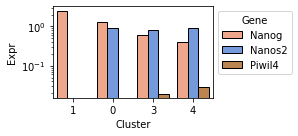

In [1571]:
plt.figure(figsize=(4,2))
g=sns.barplot(data=mature_df,x='Cluster',y='Expr',hue='Gene',palette={'Nanog':'lightsalmon','Nanos2':'cornflowerblue',
                                                                   'Piwil4':'peru'},order=order,edgecolor='black')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.yscale('log')
plt.savefig('mature_expr_germ.pdf')

In [1391]:
#Meis2 --> regulating mitotic arrest of GCs

In [1457]:
#Ptpre, Echdc2,  #https://www.genecards.org/cgi-bin/carddisp.pl?gene=PTPRE

In [1395]:
# #barplot of proportion of E13 (more mature) in each cluster
# plt.figure(figsize=(4.5,2.5))
# sns.barplot(x=sr_x,y=prop_e13,order=order,color='#7fc97f',edgecolor='black')
# plt.savefig('germ_E13_props.pdf')

**Brca-null tumor cells**

Opposite to the previous factors, spliceosome component SRSF4 induces splicing events followed by apoptosis in cancer cells when combined with the cytotoxic agent cisplatin. Knockdown of this factor reverses these splicing events and as a result significantly reduces cisplatin induced apoptosis  

Non-coding RNAs (ncRNAs) and in particular long ncRNAs (lncRNAs) can alter the chromatin environment preventing the recruitment of a repressive chromatin-splicing adapter complex and consequently regulate AS of the FGFR2

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6800274/

In [1675]:
#KIF4A, RACGAP1, CKS2, SHCBP1, and HMMR
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8075678/#:~:text=Conclusion,the%20basis%20of%20bioinformatical%20analysis.
    
brca_de = ['Brca1','Rbfox2','Srsf4','Srsf2',
          'Fgfr2' ,
          'U2af1','Casp8','Bud31', 'Rbfox1']+list(brca_markers)


#Set colors for 10 clusters
#9FD69F E13 0 
#CEC2DE E11 1
pal =['#b3cde3','#fbb4ae','#ccebc5'] #Accent hex colors
assign_colors = dict(zip([0,1,8,],pal))
assign_colors['None'] = 'lightgrey'
#Compare clusters 0 and 2, and 0 and 1 (0:1, 1: 8, 2: 0) so in sr 1,0 and 1,8
#or 2 vs everything (2 is 0)

fc_par.shape:  (1, 339, 3)
fc_s_par.shape:  (339,)


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


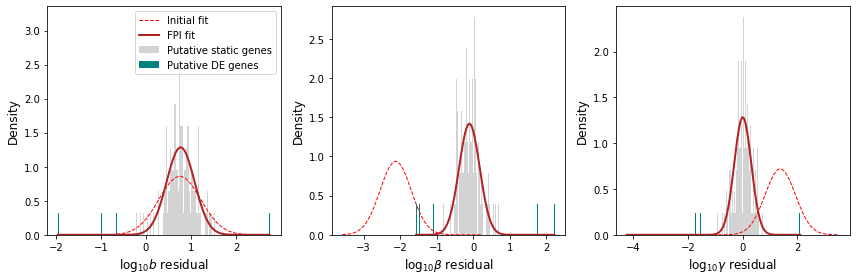

In [1676]:
#Basal vs EMT-Mid
all_filt_fcs = make_fcs(sr_all[0],chosen_sd[0][0],clus1=0,clus2=8,
                gf_rej=True,thrpars=2,thrmean=0.1,outlier_de=True,nuc=False,correct_off=True)

In [1677]:
all_filt_fcs[all_filt_fcs['gene'].isin(['Srsf4'])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
89,False,-2.068356,Srsf4,"[0, 8]",True,False,b
222,False,-1.834454,Srsf4,"[0, 8]",False,False,beta
355,False,-2.493610,Srsf4,"[0, 8]",True,False,gamma


In [1678]:
all_filt_fcs[all_filt_fcs['gene'].isin(['Sf3b1'])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
0,False,-2.407173,Sf3b1,"[0, 8]",True,False,b
133,False,-1.351809,Sf3b1,"[0, 8]",False,False,beta
266,False,-3.294279,Sf3b1,"[0, 8]",True,False,gamma


In [1049]:
np.unique(all_filt_fcs['gene'][all_filt_fcs['gene'].isin(brca_de) & all_filt_fcs['deTheta_FC'].isin([True])])

array(['Bcl2l1', 'Bcl2l11', 'Bin1', 'Cd47', 'Ceacam1', 'Cldn3', 'Enah',
       'Esrp1', 'Fbln2', 'Hif1a', 'Hipk2', 'Hnrnpm', 'Igfbp5', 'Ilf3',
       'Mdm2', 'Numb', 'Prrc2c', 'Pten', 'Rbfox2', 'Rbm10', 'Rbm6',
       'Rps6kb1', 'Sf3b1', 'Srsf4', 'Srsf5', 'Tnc', 'U2af1', 'Yap1'],
      dtype=object)

In [1050]:
all_filt_fcs[all_filt_fcs['deTheta_noDeMuS'].isin([True])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
24,False,-2.987355,Ebf1,"[0, 8]",True,True,b
125,False,-5.054526,Lars2,"[0, 8]",True,True,b
258,False,-4.713185,Lars2,"[0, 8]",True,True,beta


In [1022]:
out_marks = get_gene_DE(all_filt_fcs)

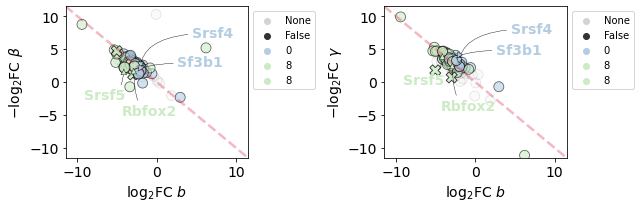

In [1023]:
names_plot = ['Srsf4','Rbfox2','Srsf5','Sf3b1'] #Tpm1 age-related https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8225046/
mark_plot = [0,8,8,0]
xpos = [6.5,-1.5,-5,5]
ypos = [5,-7.5,-5,1]
arrow = [True,True,True,True]

plot_de(out_marks,names_plot ,mark_plot,xpos,ypos,arrow,
        assign_colors,figsize=(9,3),fname='brca_basvsEMTMid.pdf',xlims=[-11.5,11.5])

fc_par.shape:  (1, 339, 3)
fc_s_par.shape:  (339,)


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


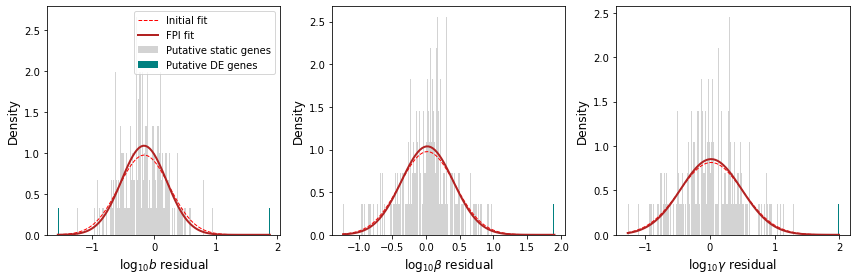

In [1647]:
#Basal vs EMT
all_filt_fcs = make_fcs(sr_all[0],chosen_sd[0][0],clus1=0,clus2=1,
                gf_rej=True,thrpars=2,thrmean=0.1,outlier_de=True,nuc=False,correct_off=True)

In [1648]:
np.unique(all_filt_fcs['gene'][all_filt_fcs['gene'].isin(brca_de) & all_filt_fcs['deTheta_FC'].isin([True])])

array(['Birc5', 'Casp8', 'Ceacam1', 'Esrp1', 'Exoc7', 'Hif1a', 'Hipk2',
       'Hnrnpa1', 'Hnrnpm', 'Ilf3', 'Mki67', 'Rbfox2', 'Srsf4', 'Tra2b',
       'Tyms', 'U2af1', 'Yap1'], dtype=object)

In [1656]:
all_filt_fcs[all_filt_fcs['gene'].isin(['Srsf4','Yap1','Rbfox2','Hnrnpa1'])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
52,False,-2.261037,Hnrnpa1,"[0, 1]",True,True,b
54,False,-2.132469,Rbfox2,"[0, 1]",True,True,b
116,True,3.371962,Srsf4,"[0, 1]",True,True,b
165,False,-2.407347,Yap1,"[0, 1]",True,True,b
227,False,-1.731741,Hnrnpa1,"[0, 1]",False,False,beta
229,False,-1.223210,Rbfox2,"[0, 1]",False,False,beta
291,False,3.152930,Srsf4,"[0, 1]",True,True,beta
340,False,-1.935686,Yap1,"[0, 1]",False,False,beta
402,False,-2.204382,Hnrnpa1,"[0, 1]",True,True,gamma
404,False,-1.661849,Rbfox2,"[0, 1]",False,False,gamma


In [1652]:
out_marks = get_gene_DE(all_filt_fcs)

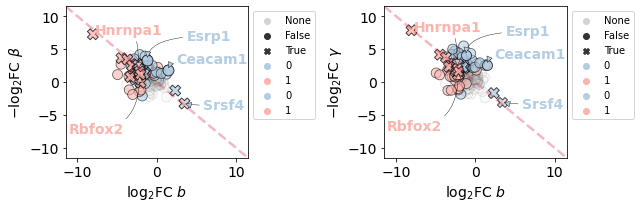

In [1665]:
names_plot = ['Srsf4','Hnrnpa1','Rbfox2','Esrp1','Ceacam1'] #Tpm1 age-related https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8225046/
mark_plot = [0,1,1,0,0]
xpos = [2.5,-5.5,-9,5,1]
ypos = [-1,5.5,-9,3,1]
arrow = [True,True,True,True,True]

plot_de(out_marks,names_plot ,mark_plot,xpos,ypos,arrow,
        assign_colors,figsize=(9,3),fname='brca_basvsEMT1.pdf',xlims=[-11.5,11.5])

In [ ]:
#Esrp1 PROGNOSTIC MARKER https://pubmed.ncbi.nlm.nih.gov/30665944/
#Hnrnpa1 rol in splicing regulation in final metastasis https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3794575/ 
#Ceacam1 inhibits metastasis

In [1612]:
#Histogram of betas after gene_rej
sr1 = sr_all[0][2]
param_names = sr1.model.get_log_name_str()
offsets = []
sr2 = sr_all[0][0]
sr3 = sr_all[0][1]

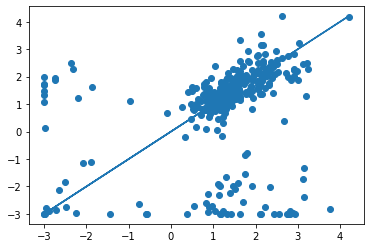

In [1613]:
plt.scatter(sr1.param_estimates[0,:,0],sr2.param_estimates[0,:,0])
plt.plot(sr1.param_estimates[0,:,0],sr1.param_estimates[0,:,0])

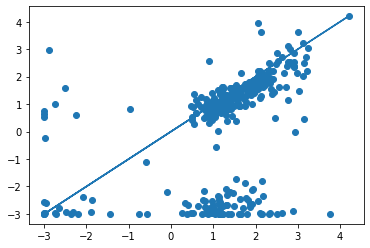

In [1614]:
plt.scatter(sr1.param_estimates[0,:,0],sr3.param_estimates[0,:,0])
plt.plot(sr1.param_estimates[0,:,0],sr1.param_estimates[0,:,0])

In [1615]:
#may need to correct for bias in b (all higher in 0 vs 8)
for r in chosen_sr[0]:
    print(r.assigns)
    print(np.sum(r.filt))


1
756
8
978
0
1076


In [1616]:


par_vals0 = np.copy(sr1.param_estimates)
par_vals1 = np.copy(sr2.param_estimates)
par_vals8 = np.copy(sr3.param_estimates)
for k in range(3):
    m1 = sr1.param_estimates[0,:,k]
    m2 = sr3.param_estimates[0,:,k]
    offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
    par_vals8[0,:,k] -= offset
    
    m2 = sr2.param_estimates[0,:,k]
    offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
    par_vals1[0,:,k] -= offset

In [1617]:
gf_rej = (~sr1.rejected_genes)&(~sr2.rejected_genes)&(~sr3.rejected_genes)

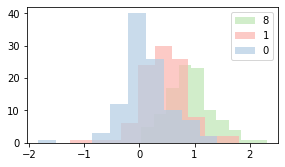

In [1620]:
plt.figure(figsize=(4.5,2.5))
plt.hist(par_vals8[0,gf_rej,1],color=assign_colors[8],alpha=0.9,label=8) #clus 8
plt.hist(par_vals1[0,gf_rej,1],color=assign_colors[1],alpha=0.7,label=1) #clus 1
plt.hist(par_vals0[0,gf_rej,1],color=assign_colors[0],alpha=0.7,label=0) #Clus 0
plt.legend()
plt.savefig('malat1_beta_hists.pdf')

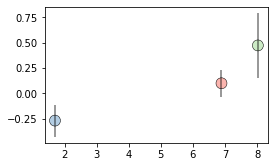

In [1645]:
#plot of splicing (Beta) of Rbfox2 vs Malat1 observed meanS in clusters
brca_sd = chosen_sd[0][0]
betas_RB = []
mal_expr = [] #approximated MeanS
sigs = []

for r,z in zip([par_vals0,par_vals1,par_vals8],[sr1,sr2,sr3]):
    betas_RB += [r[0,brca_sd.gene_names=='Rbfox2',1]]
    mal_expr += [r[0,brca_sd.gene_names=='Malat1',0] - r[0,brca_sd.gene_names=='Malat1',2]]
    sigs += [z.sigma[brca_sd.gene_names=='Rbfox2',1][0]]

plt.figure(figsize=(4,2.5))
plt.scatter(mal_expr,betas_RB,color=[assign_colors[0],assign_colors[1],assign_colors[8]],
           s=120,edgecolor='black',linewidth=0.5)
plt.errorbar(mal_expr,betas_RB,yerr=np.array(sigs)*2.576,ecolor='black',alpha=0.4,linewidth=2,ls='none')
plt.savefig('malat1_beta_rbfox.pdf')

[array([1.7]), array([6.88997707]), array([8.02442655])]